# Obtaining Data for Indian States & Italy

Delhi
Haryana
Karnataka
Kerala
Maharashtra
Punjab
Rajasthan
Tamil Nadu
Jammu and Kashmir
Ladakh
Uttar Pradesh


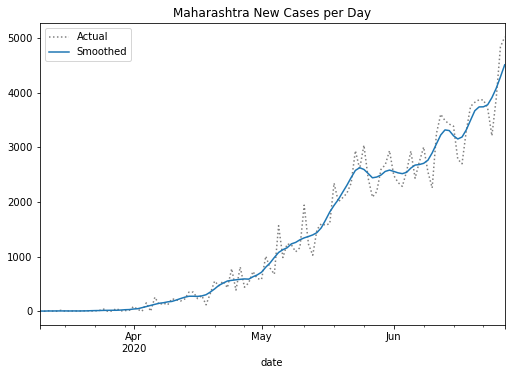

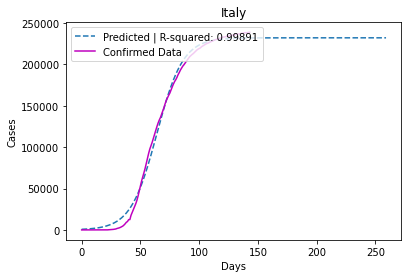

In [1]:
import pandas as pd
import numpy as np
import requests
import json

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output
def get_covid_india_data_api(url):
    response = requests.request("GET", url)
    return response.text.encode('utf8')

def flatten_and_parse_states_data(covid_data):
    flattened_data = []
    for day_data in covid_data:
        for region in day_data['regional']:
            flattened_data.append({
                'date' : day_data['day'],
                'state' : region['loc'],
                'case' : region['totalConfirmed']
            })
    
    states=pd.DataFrame(flattened_data)
    states.date = pd.to_datetime(states.date)
    return states

def fetch_covid_india_data(url):
    try:
        covid_data_json = get_covid_india_data_api(url)
        covid_data = json.loads(covid_data_json)['data']
        return flatten_and_parse_states_data(covid_data)
    except:
        print("API call failed")
        
#-------------------------------------------------------------------------
        
url = "https://api.rootnet.in/covid19-in/stats/history"

states_df = fetch_covid_india_data(url)

#-------------------------------------------------------------------------------------------------------
states_df = states_df[states_df.state.str.contains('#')== False]
only_state_names = pd.unique(states_df[['state']].values.ravel('K'))
only_state_names
states_df[states_df.state !='Jharkhand#']
states = states_df.set_index(['state','date']).squeeze()


#--------------------------------------------------------------------------------------------
state_name = 'Maharashtra'

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = states.xs(state_name).rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

#----------------------------------------------------------------------------------------------------
TODAYS_LENGTH = len(states.xs('Maharashtra'))
all_cases_list = []
for l in range(0,len(pd.unique(states_df[['state']].values.ravel('K')))-1):
    cases = states.xs(only_state_names[l]).rename(f"{only_state_names[l]} cases")
    if len(cases) == TODAYS_LENGTH:
        print(only_state_names[l])
        all_cases_list.append(cases)
#############################################################################################
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def predict_cases(name,days = 260, lst = True):
    if lst == True:
        for l in name:
            global_data2 = pd.read_csv("../input/novel-corona-virus-2019-dataset/covid_19_data.csv")
            country_data = global_data2[global_data2['Country/Region']==l]
            
            country_data = country_data.drop(['SNo','Province/State', 'Last Update'], axis=1)
            country_data = pd.pivot_table(country_data, values=['Confirmed', 'Recovered','Deaths'], index=['ObservationDate'], aggfunc=np.sum)
            country_data.tail()

            # we will want x_data to be the number of days since first confirmed and the y_data to be the confirmed data. This will be the data we use to fit a logistic curve
            x_data = range(len(country_data.index))
            y_data = country_data['Confirmed']
         
            
            
            def log_curve(x, k, x_0, ymax):
                return ymax / (1 + np.exp(-k*(x-x_0)))

            # Fit the curve
            popt, pcov = curve_fit(log_curve, x_data, y_data, bounds=([0,0,0],np.inf), maxfev=6000000)
            estimated_k, estimated_x_0, ymax= popt

            #print(len(country_data.index))
            # Plot the fitted curve
            k = estimated_k
            x_0 = estimated_x_0
            y_fitted = log_curve(range(0,days), k, x_0, ymax)
            #print(k, x_0, ymax)
            #print(y_fitted)
            y_data.tail()
            
            ###################################################################################################
            
            absError = abs(y_data- y_fitted[0:len(y_data)])

            SE = np.square(absError) # squared errors
            MSE = np.mean(SE) # mean squared errors
            RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
            Rsquared = 1.0 - (np.var(absError) / np.var(y_data))

          #  print()
          #  print('RMSE:', RMSE)
          #  print('R-squared:', Rsquared)

           # print()
            # Plot everything for illustration
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.plot(range(0,len(y_fitted)), y_fitted, '--', label='Predicted | R-squared: '+str(round(Rsquared,5)))
            ax.plot(x_data, y_data, 'm', label='Confirmed Data')
          
            ax.set_xlabel('Days') # X axis data label
            ax.set_ylabel('Cases') # Y axis data label
            ax.set_title(l)
            ax.legend(loc='upper left')
            #ax.legend('RMSE: ' + str(RMSE))
            plt.show()
        return y_data
italy_cases = predict_cases(['Italy'])

# Cleaning & Transforming Data

In [2]:
df1 = pd.read_csv('../input/india-census-yearly-data/data_2017.csv', delimiter=',')

nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')
df2 = df1.groupby('NAME').sum().reset_index()
df2 = df2.loc[:, (df2 != 0).any(axis=0)]

to_add = []

for l in df2.columns:
    if 'TOT' or '06' or 'WORK' or 'doctor' or 'Hospital' or 'Physician' or 'PHCS' or 'CHCS' in l:
        
        to_add.append(l)
to_add = [to_add[0]]+to_add[3:10]+to_add[87:]
print('Health & Demographic Variables Utilized in Model: ')
print(to_add)
df2 = df2[to_add]
        
census_data = []
for u in all_cases_list:
    if u.name == 'Delhi cases':
        census_data.append(df2.loc[df2['NAME'] == 'New Delhi'].squeeze())
    if u.name == 'Telengana cases':
        census_data.append(df2.loc[df2['NAME'] == 'TELANGANA'].squeeze())
    elif u.name == 'Jammu and Kashmir cases':
        census_data.append(df2.loc[df2['NAME'] == 'JAMMU & KASHMIR'].squeeze())
    

    else:
        census_data.append(df2.loc[df2['NAME'] == (u.name.replace(' cases','')).upper()].squeeze())

del all_cases_list[10]
del census_data[10]
del census_data[1]
censusDataList = []
for r in range(len(census_data)):
    br = []
    for g in census_data[r][2:]:
        br.append(g)
    censusDataList.append(np.array(br))

print('Census data has parts: ', len(census_data))
print('All case has parts: ', len(all_cases_list))

italy_cases1 = italy_cases
italy_cases = italy_cases[:len(italy_cases)-15]

caseList = np.array(all_cases_list)

X1 = []
for b in range(len(censusDataList)):
    X1.append((censusDataList[b].tolist()))
    
X2 = np.array(X1)

#X2 = np.array(X1) / np.array(X1).max(axis=0)

X3 = []
for q in X2:
    X3.append([q[:len(italy_cases)],italy_cases.to_list()/np.max(italy_cases.to_list())])
X3 = np.array(X3)

caseListNorm = []

for q in caseList:
    maxi = max(q)
    caseListNorm.append(q/maxi)
caseListNorm = np.array(caseListNorm)
                          


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (219,220,221,231,232,238,239,245,246,252,253,254,260,261,262,268,269,270,276,277,278,323,324,325,348,349,350) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are 1522 rows and 2537 columns
Health & Demographic Variables Utilized in Model: 
['NAME', 'TOT_P', 'TOT_M', 'TOT_F', 'P_06', 'M_06', 'F_06', 'P_SC', 'Allopathic_doctor_Required - [R]', 'Allopathic_doctor_Sanctioned - [S]', 'Allopathic_doctor_In Position - [P]', 'Allopathic_doctor_Vacant - [S-P]', 'Allopathic_doctor_Shortfall - [R-P]', 'District Hospital - Sanctioned', 'District Hospital - In Position', 'Sub District/ Sub Divisional Hospital - Sanctioned', 'Sub District/ Sub Divisional Hospital - In Position', 'Physician_CHCS_Required - [R]', 'Physician_CHCS_Sanctioned - [S]', 'Physician_CHCS_In Position - [P]', 'Physician_CHCS_Vacant - [S-P]', 'Physician_CHCS_Shortfall - [R-P]', 'Surgeon_CHCS_Required - [R]', 'Surgeon_CHCS_Sanctioned - [S]', 'Surgeon_CHCS_In Position - [P]', 'Surgeon_CHCS_Vacant - [S-P]', 'Surgeon_CHCS_Shortfall - [R-P]', 'Workers_male_subcentre_Required - [R]', 'Workers_male_subcentre_Sanctioned - [S]', 'Workers_male_subcentre_In Position - [P]', 'Workers_male_

# Data & Model Creation Functions

In [3]:
X4 =[]
Y4 = []
CensusNormalized = np.array(censusDataList) / np.array(censusDataList).max(axis=0)
from sklearn.model_selection import train_test_split
italyCasesforLstm = italy_cases1.to_list()[len(italy_cases1)-len(caseListNorm[0]):]/np.max(italy_cases1[len(italy_cases1)-len(caseListNorm[0]):].to_list())
def to_lstm(x,y, tadd, val_in=30, val_out=30):
    xt = []
    for l in range(len(x)-val_in-val_out):
        xt.append([x[l:l+val_in], tadd[:val_in]])
    
  
    yt = []
    for l in range(val_in,len(y)-val_out):
        yt.append(y[l: val_out+l])
    
    
    return xt, yt


def develop(length):
    X5 = []
    Y5 = []
    for l in range(len(caseListNorm)):
        x,y = to_lstm(x = italyCasesforLstm, y = caseListNorm[l].tolist(), tadd = CensusNormalized[l], val_in = length, val_out=length )
        X5.append(np.array(x))
        Y5.append(np.array(y))
    X5 = np.array(X5)
    Y5 = np.array(Y5)
    X6 = X5.reshape(X5.shape[0]*X5.shape[1], 2,X5.shape[3])
    Y6 = Y5.reshape(Y5.shape[0]*Y5.shape[1],Y5.shape[2],1)
    TX, tx,TY,ty = train_test_split(X6, Y6, test_size = 0.1, random_state=6)
    
    return TX, tx,TY,ty

In [4]:
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
# ML Imports

from keras.models import Sequential
from keras.layers import Input, Dense, GRU, Embedding, LSTM, Dropout, Lambda, Flatten
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.backend import square, mean
from keras.utils import Sequence
from keras.preprocessing.sequence import TimeseriesGenerator

def build_model( train_x, train_y):
    # prepare data
    
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    #train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    # instantiating the model in the strategy scope creates the model on the TPU
   
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    #model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model


TX, tx,TY,ty = develop(length = 30)
model = build_model(TX, TY)

Using TensorFlow backend.


# Compute Which Input-Output Length Performs Best on Default Model

Model Number: 3
Input Length: 3
Epoch 1/60
936/936 [==============================] - 1s 1ms/step - loss: 0.0833
Epoch 2/60
936/936 [==============================] - 0s 332us/step - loss: 0.0634
Epoch 3/60
936/936 [==============================] - 0s 331us/step - loss: 0.0556
Epoch 4/60
936/936 [==============================] - 0s 330us/step - loss: 0.0461
Epoch 5/60
936/936 [==============================] - 0s 330us/step - loss: 0.0381
Epoch 6/60
936/936 [==============================] - 0s 327us/step - loss: 0.0319
Epoch 7/60
936/936 [==============================] - 0s 324us/step - loss: 0.0282
Epoch 8/60
936/936 [==============================] - 0s 324us/step - loss: 0.0255
Epoch 9/60
936/936 [==============================] - 0s 316us/step - loss: 0.0228
Epoch 10/60
936/936 [==============================] - 0s 306us/step - loss: 0.0226
Epoch 11/60
936/936 [==============================] - 0s 305us/step - loss: 0.0189
Epoch 12/60
936/936 [==============================] - 

918/918 [==============================] - 0s 401us/step - loss: 0.0116
Epoch 25/60
918/918 [==============================] - 0s 359us/step - loss: 0.0128
Epoch 26/60
918/918 [==============================] - 0s 360us/step - loss: 0.0108
Epoch 27/60
918/918 [==============================] - 0s 362us/step - loss: 0.0096
Epoch 28/60
918/918 [==============================] - 0s 452us/step - loss: 0.0113
Epoch 29/60
918/918 [==============================] - 0s 371us/step - loss: 0.0109
Epoch 30/60
918/918 [==============================] - 0s 375us/step - loss: 0.0110
Epoch 31/60
918/918 [==============================] - 0s 369us/step - loss: 0.0097
Epoch 32/60
918/918 [==============================] - 0s 357us/step - loss: 0.0089
Epoch 33/60
918/918 [==============================] - 0s 471us/step - loss: 0.0130
Epoch 34/60
918/918 [==============================] - 0s 435us/step - loss: 0.0083
Epoch 35/60
918/918 [==============================] - 0s 397us/step - loss: 0.0137
Epoc

900/900 [==============================] - 0s 539us/step - loss: 0.0163
Epoch 49/60
900/900 [==============================] - 0s 414us/step - loss: 0.0124
Epoch 50/60
900/900 [==============================] - 0s 412us/step - loss: 0.0148
Epoch 51/60
900/900 [==============================] - 0s 406us/step - loss: 0.0091
Epoch 52/60
900/900 [==============================] - 0s 408us/step - loss: 0.0095
Epoch 53/60
900/900 [==============================] - 0s 414us/step - loss: 0.0125
Epoch 54/60
900/900 [==============================] - 0s 421us/step - loss: 0.0086
Epoch 55/60
900/900 [==============================] - 0s 414us/step - loss: 0.0098
Epoch 56/60
900/900 [==============================] - 0s 411us/step - loss: 0.0136
Epoch 57/60
900/900 [==============================] - 0s 409us/step - loss: 0.0090
Epoch 58/60
900/900 [==============================] - 0s 407us/step - loss: 0.0073
Epoch 59/60
900/900 [==============================] - 0s 410us/step - loss: 0.0069
Epoc

Epoch 1/60
864/864 [==============================] - 1s 1ms/step - loss: 0.0689
Epoch 2/60
864/864 [==============================] - 0s 520us/step - loss: 0.0521
Epoch 3/60
864/864 [==============================] - 1s 618us/step - loss: 0.0450
Epoch 4/60
864/864 [==============================] - 1s 596us/step - loss: 0.0355
Epoch 5/60
864/864 [==============================] - 0s 541us/step - loss: 0.0326
Epoch 6/60
864/864 [==============================] - 0s 510us/step - loss: 0.0281
Epoch 7/60
864/864 [==============================] - 0s 499us/step - loss: 0.0300
Epoch 8/60
864/864 [==============================] - 0s 509us/step - loss: 0.0252
Epoch 9/60
864/864 [==============================] - 0s 520us/step - loss: 0.0237
Epoch 10/60
864/864 [==============================] - 0s 512us/step - loss: 0.0208
Epoch 11/60
864/864 [==============================] - 0s 496us/step - loss: 0.0196
Epoch 12/60
864/864 [==============================] - 0s 508us/step - loss: 0.0166
Epo

846/846 [==============================] - 1s 604us/step - loss: 0.0111
Epoch 26/60
846/846 [==============================] - 1s 603us/step - loss: 0.0095
Epoch 27/60
846/846 [==============================] - 1s 632us/step - loss: 0.0123
Epoch 28/60
846/846 [==============================] - 1s 618us/step - loss: 0.0109
Epoch 29/60
846/846 [==============================] - 1s 601us/step - loss: 0.0246
Epoch 30/60
846/846 [==============================] - 1s 614us/step - loss: 0.0174
Epoch 31/60
846/846 [==============================] - 1s 613us/step - loss: 0.0116
Epoch 32/60
846/846 [==============================] - 1s 602us/step - loss: 0.0115
Epoch 33/60
846/846 [==============================] - 1s 609us/step - loss: 0.0104
Epoch 34/60
846/846 [==============================] - 1s 609us/step - loss: 0.0100
Epoch 35/60
846/846 [==============================] - 1s 595us/step - loss: 0.0088
Epoch 36/60
846/846 [==============================] - 1s 607us/step - loss: 0.0089
Epoc

828/828 [==============================] - 0s 590us/step - loss: 0.0103
Epoch 50/60
828/828 [==============================] - 0s 584us/step - loss: 0.0095
Epoch 51/60
828/828 [==============================] - 1s 621us/step - loss: 0.0093
Epoch 52/60
828/828 [==============================] - 0s 588us/step - loss: 0.0079
Epoch 53/60
828/828 [==============================] - 0s 583us/step - loss: 0.0080
Epoch 54/60
828/828 [==============================] - 0s 583us/step - loss: 0.0096
Epoch 55/60
828/828 [==============================] - 0s 579us/step - loss: 0.0066
Epoch 56/60
828/828 [==============================] - 0s 582us/step - loss: 0.0077
Epoch 57/60
828/828 [==============================] - 0s 599us/step - loss: 0.0078
Epoch 58/60
828/828 [==============================] - 0s 579us/step - loss: 0.0074
Epoch 59/60
828/828 [==============================] - 0s 584us/step - loss: 0.0059
Epoch 60/60
828/828 [==============================] - 0s 581us/step - loss: 0.0063
R-2 

Epoch 1/60
792/792 [==============================] - 1s 2ms/step - loss: 0.0610
Epoch 2/60
792/792 [==============================] - 1s 696us/step - loss: 0.0451
Epoch 3/60
792/792 [==============================] - 1s 698us/step - loss: 0.0372
Epoch 4/60
792/792 [==============================] - 1s 721us/step - loss: 0.0268
Epoch 5/60
792/792 [==============================] - 1s 688us/step - loss: 0.0215
Epoch 6/60
792/792 [==============================] - 1s 740us/step - loss: 0.0176
Epoch 7/60
792/792 [==============================] - 1s 693us/step - loss: 0.0153
Epoch 8/60
792/792 [==============================] - 1s 691us/step - loss: 0.0121
Epoch 9/60
792/792 [==============================] - 1s 680us/step - loss: 0.0179
Epoch 10/60
792/792 [==============================] - 1s 718us/step - loss: 0.0156
Epoch 11/60
792/792 [==============================] - 1s 691us/step - loss: 0.0135
Epoch 12/60
792/792 [==============================] - 1s 682us/step - loss: 0.0108
Epo

774/774 [==============================] - 1s 763us/step - loss: 0.0141
Epoch 26/60
774/774 [==============================] - 1s 754us/step - loss: 0.0097
Epoch 27/60
774/774 [==============================] - 1s 779us/step - loss: 0.0094
Epoch 28/60
774/774 [==============================] - 1s 746us/step - loss: 0.0087
Epoch 29/60
774/774 [==============================] - 1s 778us/step - loss: 0.0071
Epoch 30/60
774/774 [==============================] - 1s 784us/step - loss: 0.0065
Epoch 31/60
774/774 [==============================] - 1s 919us/step - loss: 0.0070
Epoch 32/60
774/774 [==============================] - 1s 824us/step - loss: 0.0078
Epoch 33/60
774/774 [==============================] - 1s 758us/step - loss: 0.0090
Epoch 34/60
774/774 [==============================] - 1s 757us/step - loss: 0.0100
Epoch 35/60
774/774 [==============================] - 1s 754us/step - loss: 0.0098
Epoch 36/60
774/774 [==============================] - 1s 783us/step - loss: 0.0097
Epoc

756/756 [==============================] - 1s 779us/step - loss: 0.0056
Epoch 50/60
756/756 [==============================] - 1s 775us/step - loss: 0.0051
Epoch 51/60
756/756 [==============================] - 1s 777us/step - loss: 0.0035
Epoch 52/60
756/756 [==============================] - 1s 766us/step - loss: 0.0031
Epoch 53/60
756/756 [==============================] - 1s 772us/step - loss: 0.0035
Epoch 54/60
756/756 [==============================] - 1s 777us/step - loss: 0.0050
Epoch 55/60
756/756 [==============================] - 1s 773us/step - loss: 0.0065
Epoch 56/60
756/756 [==============================] - 1s 781us/step - loss: 0.0041
Epoch 57/60
756/756 [==============================] - 1s 792us/step - loss: 0.0054
Epoch 58/60
756/756 [==============================] - 1s 1ms/step - loss: 0.0058
Epoch 59/60
756/756 [==============================] - 1s 798us/step - loss: 0.0043
Epoch 60/60
756/756 [==============================] - 1s 802us/step - loss: 0.0029
R-2 Sc

Epoch 1/60
720/720 [==============================] - 1s 2ms/step - loss: 0.0563
Epoch 2/60
720/720 [==============================] - 1s 917us/step - loss: 0.0409
Epoch 3/60
720/720 [==============================] - 1s 890us/step - loss: 0.0356
Epoch 4/60
720/720 [==============================] - 1s 909us/step - loss: 0.0311
Epoch 5/60
720/720 [==============================] - 1s 945us/step - loss: 0.0214
Epoch 6/60
720/720 [==============================] - 1s 903us/step - loss: 0.0167
Epoch 7/60
720/720 [==============================] - 1s 898us/step - loss: 0.0132
Epoch 8/60
720/720 [==============================] - 1s 913us/step - loss: 0.0145
Epoch 9/60
720/720 [==============================] - 1s 1ms/step - loss: 0.0131
Epoch 10/60
720/720 [==============================] - 1s 897us/step - loss: 0.0119
Epoch 11/60
720/720 [==============================] - 1s 911us/step - loss: 0.0115
Epoch 12/60
720/720 [==============================] - 1s 902us/step - loss: 0.0152
Epoch

702/702 [==============================] - 1s 968us/step - loss: 0.0066
Epoch 26/60
702/702 [==============================] - 1s 931us/step - loss: 0.0054
Epoch 27/60
702/702 [==============================] - 1s 913us/step - loss: 0.0049
Epoch 28/60
702/702 [==============================] - 1s 930us/step - loss: 0.0094
Epoch 29/60
702/702 [==============================] - 1s 909us/step - loss: 0.0061
Epoch 30/60
702/702 [==============================] - 1s 916us/step - loss: 0.0053
Epoch 31/60
702/702 [==============================] - 1s 913us/step - loss: 0.0048
Epoch 32/60
702/702 [==============================] - 1s 915us/step - loss: 0.0041
Epoch 33/60
702/702 [==============================] - 1s 918us/step - loss: 0.0047
Epoch 34/60
702/702 [==============================] - 1s 935us/step - loss: 0.0045
Epoch 35/60
702/702 [==============================] - 1s 923us/step - loss: 0.0052
Epoch 36/60
702/702 [==============================] - 1s 910us/step - loss: 0.0047
Epoc

684/684 [==============================] - 1s 986us/step - loss: 0.0033
Epoch 50/60
684/684 [==============================] - 1s 978us/step - loss: 0.0050
Epoch 51/60
684/684 [==============================] - 1s 979us/step - loss: 0.0032
Epoch 52/60
684/684 [==============================] - 1s 976us/step - loss: 0.0022
Epoch 53/60
684/684 [==============================] - 1s 981us/step - loss: 0.0031
Epoch 54/60
684/684 [==============================] - 1s 981us/step - loss: 0.0027
Epoch 55/60
684/684 [==============================] - 1s 985us/step - loss: 0.0028
Epoch 56/60
684/684 [==============================] - 1s 973us/step - loss: 0.0027
Epoch 57/60
684/684 [==============================] - 1s 983us/step - loss: 0.0015
Epoch 58/60
684/684 [==============================] - 1s 995us/step - loss: 0.0016
Epoch 59/60
684/684 [==============================] - 1s 1ms/step - loss: 0.0017
Epoch 60/60
684/684 [==============================] - 1s 990us/step - loss: 0.0012
R-2 Sc

Epoch 1/60
648/648 [==============================] - 2s 2ms/step - loss: 0.0509
Epoch 2/60
648/648 [==============================] - 1s 1ms/step - loss: 0.0349
Epoch 3/60
648/648 [==============================] - 1s 1ms/step - loss: 0.0292
Epoch 4/60
648/648 [==============================] - 1s 1ms/step - loss: 0.0194
Epoch 5/60
648/648 [==============================] - 1s 1ms/step - loss: 0.0126
Epoch 6/60
648/648 [==============================] - 1s 1ms/step - loss: 0.0164
Epoch 7/60
648/648 [==============================] - 1s 1ms/step - loss: 0.0123
Epoch 8/60
648/648 [==============================] - 1s 1ms/step - loss: 0.0120
Epoch 9/60
648/648 [==============================] - 1s 1ms/step - loss: 0.0103
Epoch 10/60
648/648 [==============================] - 1s 1ms/step - loss: 0.0087
Epoch 11/60
648/648 [==============================] - 1s 1ms/step - loss: 0.0088
Epoch 12/60
648/648 [==============================] - 1s 1ms/step - loss: 0.0085
Epoch 13/60
648/648 [====

630/630 [==============================] - 1s 1ms/step - loss: 0.0024
Epoch 28/60
630/630 [==============================] - 1s 1ms/step - loss: 0.0036
Epoch 29/60
630/630 [==============================] - 1s 1ms/step - loss: 0.0026
Epoch 30/60
630/630 [==============================] - 1s 1ms/step - loss: 0.0042
Epoch 31/60
630/630 [==============================] - 1s 1ms/step - loss: 0.0028
Epoch 32/60
630/630 [==============================] - 1s 1ms/step - loss: 0.0032
Epoch 33/60
630/630 [==============================] - 1s 1ms/step - loss: 0.0028
Epoch 34/60
630/630 [==============================] - 1s 1ms/step - loss: 0.0022
Epoch 35/60
630/630 [==============================] - 1s 1ms/step - loss: 0.0018
Epoch 36/60
630/630 [==============================] - 1s 1ms/step - loss: 0.0017
Epoch 37/60
630/630 [==============================] - 1s 1ms/step - loss: 0.0019
Epoch 38/60
630/630 [==============================] - 1s 1ms/step - loss: 0.0025
Epoch 39/60
630/630 [=======

612/612 [==============================] - 1s 1ms/step - loss: 0.0015
Epoch 54/60
612/612 [==============================] - 1s 1ms/step - loss: 0.0021
Epoch 55/60
612/612 [==============================] - 1s 1ms/step - loss: 0.0018
Epoch 56/60
612/612 [==============================] - 1s 1ms/step - loss: 0.0010
Epoch 57/60
612/612 [==============================] - 1s 1ms/step - loss: 8.7440e-04
Epoch 58/60
612/612 [==============================] - 1s 1ms/step - loss: 8.0163e-04
Epoch 59/60
612/612 [==============================] - 1s 1ms/step - loss: 0.0013
Epoch 60/60
612/612 [==============================] - 1s 1ms/step - loss: 0.0015
R-2 Score:  0.9438365700044755
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 200)               177600    
_________________________________________________________________
repeat_vector_36 (RepeatVect (

576/576 [==============================] - 1s 1ms/step - loss: 0.0169
Epoch 5/60
576/576 [==============================] - 1s 1ms/step - loss: 0.0112
Epoch 6/60
576/576 [==============================] - 1s 1ms/step - loss: 0.0125
Epoch 7/60
576/576 [==============================] - 1s 1ms/step - loss: 0.0123
Epoch 8/60
576/576 [==============================] - 1s 1ms/step - loss: 0.0107
Epoch 9/60
576/576 [==============================] - 1s 1ms/step - loss: 0.0100
Epoch 10/60
576/576 [==============================] - 1s 1ms/step - loss: 0.0076
Epoch 11/60
576/576 [==============================] - 1s 1ms/step - loss: 0.0070
Epoch 12/60
576/576 [==============================] - 1s 1ms/step - loss: 0.0054
Epoch 13/60
576/576 [==============================] - 1s 1ms/step - loss: 0.0046
Epoch 14/60
576/576 [==============================] - 1s 1ms/step - loss: 0.0046
Epoch 15/60
576/576 [==============================] - 1s 1ms/step - loss: 0.0042
Epoch 16/60
576/576 [============

558/558 [==============================] - 1s 1ms/step - loss: 0.0014
Epoch 31/60
558/558 [==============================] - 1s 1ms/step - loss: 0.0015
Epoch 32/60
558/558 [==============================] - 1s 1ms/step - loss: 0.0024
Epoch 33/60
558/558 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 34/60
558/558 [==============================] - 1s 1ms/step - loss: 0.0010
Epoch 35/60
558/558 [==============================] - 1s 1ms/step - loss: 8.3535e-04
Epoch 36/60
558/558 [==============================] - 1s 1ms/step - loss: 8.1896e-04
Epoch 37/60
558/558 [==============================] - 1s 2ms/step - loss: 0.0013
Epoch 38/60
558/558 [==============================] - 1s 1ms/step - loss: 0.0012
Epoch 39/60
558/558 [==============================] - 1s 1ms/step - loss: 9.7401e-04
Epoch 40/60
558/558 [==============================] - 1s 1ms/step - loss: 8.1250e-04
Epoch 41/60
558/558 [==============================] - 1s 1ms/step - loss: 7.8775e-04
Epoch 42

540/540 [==============================] - 1s 2ms/step - loss: 6.3336e-04
Epoch 56/60
540/540 [==============================] - 1s 1ms/step - loss: 6.3332e-04
Epoch 57/60
540/540 [==============================] - 1s 1ms/step - loss: 6.9901e-04
Epoch 58/60
540/540 [==============================] - 1s 1ms/step - loss: 6.4597e-04
Epoch 59/60
540/540 [==============================] - 1s 1ms/step - loss: 7.5945e-04
Epoch 60/60
540/540 [==============================] - 1s 1ms/step - loss: 0.0011
R-2 Score:  0.9732705588507272
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_71 (LSTM)               (None, 200)               180800    
_________________________________________________________________
repeat_vector_40 (RepeatVect (None, 25, 200)           0         
_________________________________________________________________
lstm_72 (LSTM)               (None, 25, 200)      

504/504 [==============================] - 1s 2ms/step - loss: 0.0093
Epoch 7/60
504/504 [==============================] - 1s 2ms/step - loss: 0.0080
Epoch 8/60
504/504 [==============================] - 1s 1ms/step - loss: 0.0068
Epoch 9/60
504/504 [==============================] - 1s 1ms/step - loss: 0.0073
Epoch 10/60
504/504 [==============================] - 1s 1ms/step - loss: 0.0065
Epoch 11/60
504/504 [==============================] - 1s 2ms/step - loss: 0.0061
Epoch 12/60
504/504 [==============================] - 1s 1ms/step - loss: 0.0048
Epoch 13/60
504/504 [==============================] - 1s 1ms/step - loss: 0.0050
Epoch 14/60
504/504 [==============================] - 1s 1ms/step - loss: 0.0042
Epoch 15/60
504/504 [==============================] - 1s 1ms/step - loss: 0.0033
Epoch 16/60
504/504 [==============================] - 1s 1ms/step - loss: 0.0027
Epoch 17/60
504/504 [==============================] - 1s 1ms/step - loss: 0.0023
Epoch 18/60
504/504 [==========

486/486 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 32/60
486/486 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 33/60
486/486 [==============================] - 1s 2ms/step - loss: 0.0017
Epoch 34/60
486/486 [==============================] - 1s 2ms/step - loss: 0.0017
Epoch 35/60
486/486 [==============================] - 1s 2ms/step - loss: 0.0018
Epoch 36/60
486/486 [==============================] - 1s 2ms/step - loss: 0.0015
Epoch 37/60
486/486 [==============================] - 1s 2ms/step - loss: 0.0015
Epoch 38/60
486/486 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 39/60
486/486 [==============================] - 1s 2ms/step - loss: 9.3792e-04
Epoch 40/60
486/486 [==============================] - 1s 2ms/step - loss: 9.4668e-04
Epoch 41/60
486/486 [==============================] - 1s 2ms/step - loss: 0.0016
Epoch 42/60
486/486 [==============================] - 1s 2ms/step - loss: 0.0034
Epoch 43/60
486/486 

468/468 [==============================] - 1s 2ms/step - loss: 7.2427e-04
Epoch 56/60
468/468 [==============================] - 1s 2ms/step - loss: 7.2830e-04
Epoch 57/60
468/468 [==============================] - 1s 2ms/step - loss: 0.0013
Epoch 58/60
468/468 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 59/60
468/468 [==============================] - 1s 2ms/step - loss: 0.0010
Epoch 60/60
468/468 [==============================] - 1s 2ms/step - loss: 7.0254e-04
R-2 Score:  0.9581093279743033
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_79 (LSTM)               (None, 200)               184000    
_________________________________________________________________
repeat_vector_44 (RepeatVect (None, 29, 200)           0         
_________________________________________________________________
lstm_80 (LSTM)               (None, 29, 200)           320

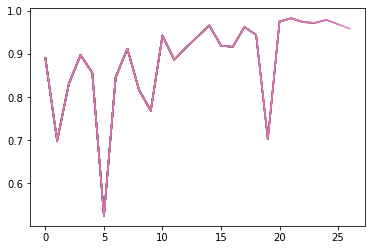

In [84]:
modelList = []
maxima = []
inList = []
for l in range(3,30):
    print('Model Number: '+ str(l))
    print('Input Length: '+str(l))
    TX, tx, TY, ty = develop(length = l)
    model = build_model(TX, TY)
    model.fit(TX, TY, epochs = 60, batch_size = 64)
    y_hat = model.predict(tx)
    accy = r2(y_hat.reshape(y_hat.shape[0],y_hat.shape[1]),ty.reshape(y_hat.shape[0],y_hat.shape[1]))

    print('R-2 Score: ', str(accy))
    maxima.append(accy)
    modelList.append(model.summary())
    inList.append(l)
    plt.plot(maxima)
    print('-----------------------------------------------------------------')
    print(' ')
    
lengthOfInput = inList[np.argmax(maxima)]

In [5]:
#print('Best Input length: ', lengthOfInput)
#print('Accuracy Achieved: ', maxima[np.argmax(maxima)])

NameError: name 'lengthOfInput' is not defined

# Creating Weighing Model

In [7]:
pip install keras-tuner

     |████████████████████████████████| 54 kB 1.6 MB/s eta 0:00:011
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-py3-none-any.whl size=73198 sha256=6758022fe88b5c149ad8e5d867b0f6aaeb95ade3f77f2d4da11c9bd188da4b5e
  Stored in directory: /root/.cache/pip/wheels/0b/cf/2f/1a1749d3a3650fac3305a8d7f9237b6de7c41068e2f8520ca2
  Created wheel for terminaltables: filename=terminaltables-3.1.0-py3-none-any.whl size=15354 sha256=e752972ddfc72eebc09ac44a22c10ef5c9583a426fb4ad7283bc8e06ee2a1ed5
  Stored in directory: /root/.cache/pip/wheels/ba/ad/c8/2d98360791161cd3db6daf6b5e730f34021fc9367d5879f497
Successfully built keras-tuner terminaltables
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [33]:
TX, tx, TY, ty = develop(length = 24)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, LSTM, Dropout, Lambda, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
from tensorflow.keras.utils import Sequence
#from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import tensorflow
n_timesteps, n_features, n_outputs = tx.shape[1],tx.shape[2], ty.shape[1]

def build_model(hp):
    
    model = Sequential()
    model.add(LSTM(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32), 
                   activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'
                ), input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32), 
                   activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32), activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'
                ))))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer=tensorflow.keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
            metrics=[keras.metrics.RootMeanSquaredError(), 'mse'])
    return model

tuner = RandomSearch(
    build_model,
    objective='mse',
    max_trials=4,
    executions_per_trial=5,
    directory='my_dir',
    project_name='COVIDstateModel')

tuner.search_space_summary()

In [34]:
tuner.search(TX, TY,
             epochs=60,
             validation_data=(tx, ty))


Train on 558 samples, validate on 62 samples
Epoch 1/60
558/558 [==============================] - ETA: 28s - loss: 0.4176 - root_mean_squared_error: 0.6463 - mse: 0.41 - ETA: 13s - loss: 44.0940 - root_mean_squared_error: 3.6433 - mse: 44.09 - ETA: 8s - loss: 32.0838 - root_mean_squared_error: 4.3169 - mse: 32.0838 - ETA: 6s - loss: 26.1313 - root_mean_squared_error: 4.5157 - mse: 26.131 - ETA: 4s - loss: 21.8375 - root_mean_squared_error: 4.5472 - mse: 21.837 - ETA: 3s - loss: 18.3567 - root_mean_squared_error: 4.5034 - mse: 18.356 - ETA: 3s - loss: 15.7471 - root_mean_squared_error: 4.4269 - mse: 15.747 - ETA: 2s - loss: 13.7964 - root_mean_squared_error: 4.3379 - mse: 13.796 - ETA: 2s - loss: 12.2872 - root_mean_squared_error: 4.2454 - mse: 12.287 - ETA: 1s - loss: 11.0796 - root_mean_squared_error: 4.1537 - mse: 11.079 - ETA: 1s - loss: 10.0822 - root_mean_squared_error: 4.0647 - mse: 10.082 - ETA: 1s - loss: 9.2480 - root_mean_squared_error: 3.9794 - mse: 9.2480  - ETA: 0s - loss

558/558 [==============================] - ETA: 0s - loss: 0.0348 - root_mean_squared_error: 1.0845 - mse: 0.034 - ETA: 0s - loss: 0.0349 - root_mean_squared_error: 1.0818 - mse: 0.034 - ETA: 0s - loss: 0.0420 - root_mean_squared_error: 1.0792 - mse: 0.042 - ETA: 0s - loss: 0.0408 - root_mean_squared_error: 1.0766 - mse: 0.040 - ETA: 0s - loss: 0.0421 - root_mean_squared_error: 1.0741 - mse: 0.042 - ETA: 0s - loss: 0.0419 - root_mean_squared_error: 1.0715 - mse: 0.041 - ETA: 0s - loss: 0.0436 - root_mean_squared_error: 1.0690 - mse: 0.043 - ETA: 0s - loss: 0.0426 - root_mean_squared_error: 1.0665 - mse: 0.042 - ETA: 0s - loss: 0.0434 - root_mean_squared_error: 1.0640 - mse: 0.043 - ETA: 0s - loss: 0.0446 - root_mean_squared_error: 1.0616 - mse: 0.044 - ETA: 0s - loss: 0.0433 - root_mean_squared_error: 1.0592 - mse: 0.043 - ETA: 0s - loss: 0.0461 - root_mean_squared_error: 1.0568 - mse: 0.046 - ETA: 0s - loss: 0.0458 - root_mean_squared_error: 1.0544 - mse: 0.045 - ETA: 0s - loss: 0.045

558/558 [==============================] - ETA: 0s - loss: 0.0761 - root_mean_squared_error: 0.7840 - mse: 0.076 - ETA: 0s - loss: 0.1340 - root_mean_squared_error: 0.7833 - mse: 0.134 - ETA: 0s - loss: 0.1136 - root_mean_squared_error: 0.7825 - mse: 0.113 - ETA: 0s - loss: 0.1068 - root_mean_squared_error: 0.7816 - mse: 0.106 - ETA: 0s - loss: 0.1043 - root_mean_squared_error: 0.7808 - mse: 0.104 - ETA: 0s - loss: 0.1300 - root_mean_squared_error: 0.7801 - mse: 0.130 - ETA: 0s - loss: 0.1224 - root_mean_squared_error: 0.7793 - mse: 0.122 - ETA: 0s - loss: 0.1175 - root_mean_squared_error: 0.7785 - mse: 0.117 - ETA: 0s - loss: 0.1142 - root_mean_squared_error: 0.7777 - mse: 0.114 - ETA: 0s - loss: 0.1107 - root_mean_squared_error: 0.7769 - mse: 0.110 - ETA: 0s - loss: 0.1080 - root_mean_squared_error: 0.7761 - mse: 0.108 - ETA: 0s - loss: 0.1130 - root_mean_squared_error: 0.7753 - mse: 0.113 - ETA: 0s - loss: 0.1121 - root_mean_squared_error: 0.7746 - mse: 0.112 - ETA: 0s - loss: 0.111

558/558 [==============================] - ETA: 1s - loss: 0.0444 - root_mean_squared_error: 0.6548 - mse: 0.044 - ETA: 1s - loss: 0.0429 - root_mean_squared_error: 0.6543 - mse: 0.042 - ETA: 1s - loss: 0.0476 - root_mean_squared_error: 0.6538 - mse: 0.047 - ETA: 1s - loss: 0.0450 - root_mean_squared_error: 0.6533 - mse: 0.045 - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.6528 - mse: 0.045 - ETA: 0s - loss: 0.0436 - root_mean_squared_error: 0.6523 - mse: 0.043 - ETA: 0s - loss: 0.0419 - root_mean_squared_error: 0.6518 - mse: 0.041 - ETA: 0s - loss: 0.0424 - root_mean_squared_error: 0.6513 - mse: 0.042 - ETA: 0s - loss: 0.0427 - root_mean_squared_error: 0.6508 - mse: 0.042 - ETA: 0s - loss: 0.0426 - root_mean_squared_error: 0.6503 - mse: 0.042 - ETA: 0s - loss: 0.0433 - root_mean_squared_error: 0.6499 - mse: 0.043 - ETA: 0s - loss: 0.0431 - root_mean_squared_error: 0.6494 - mse: 0.043 - ETA: 0s - loss: 0.0432 - root_mean_squared_error: 0.6489 - mse: 0.043 - ETA: 0s - loss: 0.043

558/558 [==============================] - ETA: 0s - loss: 0.0278 - root_mean_squared_error: 0.5777 - mse: 0.027 - ETA: 0s - loss: 0.0373 - root_mean_squared_error: 0.5773 - mse: 0.037 - ETA: 0s - loss: 0.0424 - root_mean_squared_error: 0.5770 - mse: 0.042 - ETA: 0s - loss: 0.0408 - root_mean_squared_error: 0.5767 - mse: 0.040 - ETA: 0s - loss: 0.0402 - root_mean_squared_error: 0.5764 - mse: 0.040 - ETA: 0s - loss: 0.0406 - root_mean_squared_error: 0.5761 - mse: 0.040 - ETA: 0s - loss: 0.0393 - root_mean_squared_error: 0.5757 - mse: 0.039 - ETA: 0s - loss: 0.0403 - root_mean_squared_error: 0.5754 - mse: 0.040 - ETA: 0s - loss: 0.0411 - root_mean_squared_error: 0.5751 - mse: 0.041 - ETA: 0s - loss: 0.0419 - root_mean_squared_error: 0.5748 - mse: 0.041 - ETA: 0s - loss: 0.0429 - root_mean_squared_error: 0.5745 - mse: 0.042 - ETA: 0s - loss: 0.0422 - root_mean_squared_error: 0.5742 - mse: 0.042 - ETA: 0s - loss: 0.0424 - root_mean_squared_error: 0.5738 - mse: 0.042 - ETA: 0s - loss: 0.043

558/558 [==============================] - ETA: 0s - loss: 0.0626 - root_mean_squared_error: 0.5256 - mse: 0.062 - ETA: 0s - loss: 0.0552 - root_mean_squared_error: 0.5254 - mse: 0.055 - ETA: 0s - loss: 0.0548 - root_mean_squared_error: 0.5252 - mse: 0.054 - ETA: 0s - loss: 0.0492 - root_mean_squared_error: 0.5250 - mse: 0.049 - ETA: 0s - loss: 0.0504 - root_mean_squared_error: 0.5247 - mse: 0.050 - ETA: 0s - loss: 0.0490 - root_mean_squared_error: 0.5245 - mse: 0.049 - ETA: 0s - loss: 0.0484 - root_mean_squared_error: 0.5243 - mse: 0.048 - ETA: 0s - loss: 0.0475 - root_mean_squared_error: 0.5241 - mse: 0.047 - ETA: 0s - loss: 0.0462 - root_mean_squared_error: 0.5238 - mse: 0.046 - ETA: 0s - loss: 0.0466 - root_mean_squared_error: 0.5236 - mse: 0.046 - ETA: 0s - loss: 0.0458 - root_mean_squared_error: 0.5234 - mse: 0.045 - ETA: 0s - loss: 0.0472 - root_mean_squared_error: 0.5232 - mse: 0.047 - ETA: 0s - loss: 0.0476 - root_mean_squared_error: 0.5230 - mse: 0.047 - ETA: 0s - loss: 0.047

558/558 [==============================] - ETA: 0s - loss: 0.0501 - root_mean_squared_error: 0.4884 - mse: 0.050 - ETA: 0s - loss: 0.0573 - root_mean_squared_error: 0.4882 - mse: 0.057 - ETA: 0s - loss: 0.0537 - root_mean_squared_error: 0.4881 - mse: 0.053 - ETA: 0s - loss: 0.0571 - root_mean_squared_error: 0.4879 - mse: 0.057 - ETA: 0s - loss: 0.0567 - root_mean_squared_error: 0.4877 - mse: 0.056 - ETA: 0s - loss: 0.0566 - root_mean_squared_error: 0.4876 - mse: 0.056 - ETA: 0s - loss: 0.0554 - root_mean_squared_error: 0.4874 - mse: 0.055 - ETA: 0s - loss: 0.0542 - root_mean_squared_error: 0.4873 - mse: 0.054 - ETA: 0s - loss: 0.0542 - root_mean_squared_error: 0.4871 - mse: 0.054 - ETA: 0s - loss: 0.0537 - root_mean_squared_error: 0.4869 - mse: 0.053 - ETA: 0s - loss: 0.0532 - root_mean_squared_error: 0.4868 - mse: 0.053 - ETA: 0s - loss: 0.0530 - root_mean_squared_error: 0.4866 - mse: 0.053 - ETA: 0s - loss: 0.0519 - root_mean_squared_error: 0.4865 - mse: 0.051 - ETA: 0s - loss: 0.051

558/558 [==============================] - ETA: 1s - loss: 0.0442 - root_mean_squared_error: 0.4601 - mse: 0.044 - ETA: 0s - loss: 0.0401 - root_mean_squared_error: 0.4600 - mse: 0.040 - ETA: 0s - loss: 0.0398 - root_mean_squared_error: 0.4598 - mse: 0.039 - ETA: 0s - loss: 0.0426 - root_mean_squared_error: 0.4597 - mse: 0.042 - ETA: 0s - loss: 0.0445 - root_mean_squared_error: 0.4596 - mse: 0.044 - ETA: 0s - loss: 0.0434 - root_mean_squared_error: 0.4594 - mse: 0.043 - ETA: 0s - loss: 0.0420 - root_mean_squared_error: 0.4593 - mse: 0.042 - ETA: 0s - loss: 0.0443 - root_mean_squared_error: 0.4592 - mse: 0.044 - ETA: 0s - loss: 0.0470 - root_mean_squared_error: 0.4590 - mse: 0.047 - ETA: 0s - loss: 0.0468 - root_mean_squared_error: 0.4589 - mse: 0.046 - ETA: 0s - loss: 0.0472 - root_mean_squared_error: 0.4588 - mse: 0.047 - ETA: 0s - loss: 0.0472 - root_mean_squared_error: 0.4587 - mse: 0.047 - ETA: 0s - loss: 0.0471 - root_mean_squared_error: 0.4585 - mse: 0.047 - ETA: 0s - loss: 0.046

558/558 [==============================] - ETA: 0s - loss: 0.0301 - root_mean_squared_error: 0.4374 - mse: 0.030 - ETA: 0s - loss: 0.0395 - root_mean_squared_error: 0.4373 - mse: 0.039 - ETA: 0s - loss: 0.0426 - root_mean_squared_error: 0.4372 - mse: 0.042 - ETA: 0s - loss: 0.0428 - root_mean_squared_error: 0.4371 - mse: 0.042 - ETA: 0s - loss: 0.0445 - root_mean_squared_error: 0.4370 - mse: 0.044 - ETA: 0s - loss: 0.0464 - root_mean_squared_error: 0.4369 - mse: 0.046 - ETA: 0s - loss: 0.0460 - root_mean_squared_error: 0.4368 - mse: 0.046 - ETA: 0s - loss: 0.0472 - root_mean_squared_error: 0.4367 - mse: 0.047 - ETA: 0s - loss: 0.0472 - root_mean_squared_error: 0.4366 - mse: 0.047 - ETA: 0s - loss: 0.0463 - root_mean_squared_error: 0.4365 - mse: 0.046 - ETA: 0s - loss: 0.0465 - root_mean_squared_error: 0.4364 - mse: 0.046 - ETA: 0s - loss: 0.0478 - root_mean_squared_error: 0.4363 - mse: 0.047 - ETA: 0s - loss: 0.0469 - root_mean_squared_error: 0.4362 - mse: 0.046 - ETA: 0s - loss: 0.046

558/558 [==============================] - ETA: 0s - loss: 0.0692 - root_mean_squared_error: 0.4197 - mse: 0.069 - ETA: 0s - loss: 0.0479 - root_mean_squared_error: 0.4196 - mse: 0.047 - ETA: 0s - loss: 0.0430 - root_mean_squared_error: 0.4195 - mse: 0.043 - ETA: 0s - loss: 0.0429 - root_mean_squared_error: 0.4194 - mse: 0.042 - ETA: 0s - loss: 0.0460 - root_mean_squared_error: 0.4193 - mse: 0.046 - ETA: 0s - loss: 0.0459 - root_mean_squared_error: 0.4192 - mse: 0.045 - ETA: 0s - loss: 0.0483 - root_mean_squared_error: 0.4191 - mse: 0.048 - ETA: 0s - loss: 0.0464 - root_mean_squared_error: 0.4190 - mse: 0.046 - ETA: 0s - loss: 0.0452 - root_mean_squared_error: 0.4190 - mse: 0.045 - ETA: 0s - loss: 0.0494 - root_mean_squared_error: 0.4189 - mse: 0.049 - ETA: 0s - loss: 0.0476 - root_mean_squared_error: 0.4188 - mse: 0.047 - ETA: 0s - loss: 0.0481 - root_mean_squared_error: 0.4187 - mse: 0.048 - ETA: 0s - loss: 0.0475 - root_mean_squared_error: 0.4186 - mse: 0.047 - ETA: 0s - loss: 0.047

558/558 [==============================] - ETA: 0s - loss: 0.0356 - root_mean_squared_error: 0.4039 - mse: 0.035 - ETA: 0s - loss: 0.0403 - root_mean_squared_error: 0.4038 - mse: 0.040 - ETA: 0s - loss: 0.0420 - root_mean_squared_error: 0.4037 - mse: 0.042 - ETA: 0s - loss: 0.0443 - root_mean_squared_error: 0.4036 - mse: 0.044 - ETA: 0s - loss: 0.0435 - root_mean_squared_error: 0.4036 - mse: 0.043 - ETA: 0s - loss: 0.0450 - root_mean_squared_error: 0.4035 - mse: 0.045 - ETA: 0s - loss: 0.0466 - root_mean_squared_error: 0.4034 - mse: 0.046 - ETA: 0s - loss: 0.0484 - root_mean_squared_error: 0.4034 - mse: 0.048 - ETA: 0s - loss: 0.0500 - root_mean_squared_error: 0.4033 - mse: 0.050 - ETA: 0s - loss: 0.0499 - root_mean_squared_error: 0.4032 - mse: 0.049 - ETA: 0s - loss: 0.0496 - root_mean_squared_error: 0.4032 - mse: 0.049 - ETA: 0s - loss: 0.0497 - root_mean_squared_error: 0.4031 - mse: 0.049 - ETA: 0s - loss: 0.0492 - root_mean_squared_error: 0.4030 - mse: 0.049 - ETA: 0s - loss: 0.048

558/558 [==============================] - ETA: 0s - loss: 0.0278 - root_mean_squared_error: 0.3916 - mse: 0.027 - ETA: 0s - loss: 0.0601 - root_mean_squared_error: 0.3916 - mse: 0.060 - ETA: 0s - loss: 0.0531 - root_mean_squared_error: 0.3915 - mse: 0.053 - ETA: 0s - loss: 0.0545 - root_mean_squared_error: 0.3915 - mse: 0.054 - ETA: 0s - loss: 0.0516 - root_mean_squared_error: 0.3914 - mse: 0.051 - ETA: 0s - loss: 0.0512 - root_mean_squared_error: 0.3913 - mse: 0.051 - ETA: 0s - loss: 0.0507 - root_mean_squared_error: 0.3913 - mse: 0.050 - ETA: 0s - loss: 0.0501 - root_mean_squared_error: 0.3912 - mse: 0.050 - ETA: 0s - loss: 0.0493 - root_mean_squared_error: 0.3912 - mse: 0.049 - ETA: 0s - loss: 0.0487 - root_mean_squared_error: 0.3911 - mse: 0.048 - ETA: 0s - loss: 0.0487 - root_mean_squared_error: 0.3910 - mse: 0.048 - ETA: 0s - loss: 0.0493 - root_mean_squared_error: 0.3910 - mse: 0.049 - ETA: 0s - loss: 0.0496 - root_mean_squared_error: 0.3909 - mse: 0.049 - ETA: 0s - loss: 0.049

558/558 [==============================] - ETA: 28s - loss: 0.1486 - root_mean_squared_error: 0.3855 - mse: 0.14 - ETA: 13s - loss: 45.5406 - root_mean_squared_error: 3.5669 - mse: 45.54 - ETA: 8s - loss: 31.5452 - root_mean_squared_error: 4.2501 - mse: 31.5452 - ETA: 6s - loss: 25.8189 - root_mean_squared_error: 4.4579 - mse: 25.818 - ETA: 4s - loss: 21.4656 - root_mean_squared_error: 4.4929 - mse: 21.465 - ETA: 3s - loss: 18.0922 - root_mean_squared_error: 4.4530 - mse: 18.092 - ETA: 3s - loss: 15.5714 - root_mean_squared_error: 4.3806 - mse: 15.571 - ETA: 2s - loss: 13.6323 - root_mean_squared_error: 4.2946 - mse: 13.632 - ETA: 2s - loss: 12.1303 - root_mean_squared_error: 4.2044 - mse: 12.130 - ETA: 1s - loss: 10.9351 - root_mean_squared_error: 4.1146 - mse: 10.935 - ETA: 1s - loss: 9.9653 - root_mean_squared_error: 4.0275 - mse: 9.9653  - ETA: 1s - loss: 9.1543 - root_mean_squared_error: 3.9440 - mse: 9.154 - ETA: 0s - loss: 8.4667 - root_mean_squared_error: 3.8645 - mse: 8.466 - 

558/558 [==============================] - ETA: 0s - loss: 0.0318 - root_mean_squared_error: 1.0812 - mse: 0.031 - ETA: 0s - loss: 0.0368 - root_mean_squared_error: 1.0785 - mse: 0.036 - ETA: 0s - loss: 0.0383 - root_mean_squared_error: 1.0759 - mse: 0.038 - ETA: 0s - loss: 0.0418 - root_mean_squared_error: 1.0733 - mse: 0.041 - ETA: 0s - loss: 0.0426 - root_mean_squared_error: 1.0708 - mse: 0.042 - ETA: 0s - loss: 0.0429 - root_mean_squared_error: 1.0683 - mse: 0.042 - ETA: 0s - loss: 0.0422 - root_mean_squared_error: 1.0657 - mse: 0.042 - ETA: 0s - loss: 0.0429 - root_mean_squared_error: 1.0633 - mse: 0.042 - ETA: 0s - loss: 0.0456 - root_mean_squared_error: 1.0608 - mse: 0.045 - ETA: 0s - loss: 0.0449 - root_mean_squared_error: 1.0584 - mse: 0.044 - ETA: 0s - loss: 0.0449 - root_mean_squared_error: 1.0560 - mse: 0.044 - ETA: 0s - loss: 0.0441 - root_mean_squared_error: 1.0536 - mse: 0.044 - ETA: 0s - loss: 0.0430 - root_mean_squared_error: 1.0512 - mse: 0.043 - ETA: 0s - loss: 0.043

558/558 [==============================] - ETA: 0s - loss: 0.0647 - root_mean_squared_error: 0.7811 - mse: 0.064 - ETA: 0s - loss: 0.0474 - root_mean_squared_error: 0.7801 - mse: 0.047 - ETA: 0s - loss: 0.0492 - root_mean_squared_error: 0.7792 - mse: 0.049 - ETA: 0s - loss: 0.0451 - root_mean_squared_error: 0.7783 - mse: 0.045 - ETA: 0s - loss: 0.0436 - root_mean_squared_error: 0.7773 - mse: 0.043 - ETA: 0s - loss: 0.0437 - root_mean_squared_error: 0.7764 - mse: 0.043 - ETA: 0s - loss: 0.0422 - root_mean_squared_error: 0.7755 - mse: 0.042 - ETA: 0s - loss: 0.0420 - root_mean_squared_error: 0.7746 - mse: 0.042 - ETA: 0s - loss: 0.0410 - root_mean_squared_error: 0.7737 - mse: 0.041 - ETA: 0s - loss: 0.0415 - root_mean_squared_error: 0.7728 - mse: 0.041 - ETA: 0s - loss: 0.0428 - root_mean_squared_error: 0.7719 - mse: 0.042 - ETA: 0s - loss: 0.0432 - root_mean_squared_error: 0.7710 - mse: 0.043 - ETA: 0s - loss: 0.0437 - root_mean_squared_error: 0.7702 - mse: 0.043 - ETA: 0s - loss: 0.044

558/558 [==============================] - ETA: 0s - loss: 0.0543 - root_mean_squared_error: 0.6499 - mse: 0.054 - ETA: 0s - loss: 0.0509 - root_mean_squared_error: 0.6494 - mse: 0.050 - ETA: 0s - loss: 0.0469 - root_mean_squared_error: 0.6489 - mse: 0.046 - ETA: 0s - loss: 0.0468 - root_mean_squared_error: 0.6484 - mse: 0.046 - ETA: 0s - loss: 0.0446 - root_mean_squared_error: 0.6479 - mse: 0.044 - ETA: 0s - loss: 0.0503 - root_mean_squared_error: 0.6474 - mse: 0.050 - ETA: 0s - loss: 0.0496 - root_mean_squared_error: 0.6469 - mse: 0.049 - ETA: 0s - loss: 0.0494 - root_mean_squared_error: 0.6464 - mse: 0.049 - ETA: 0s - loss: 0.0488 - root_mean_squared_error: 0.6460 - mse: 0.048 - ETA: 0s - loss: 0.0488 - root_mean_squared_error: 0.6455 - mse: 0.048 - ETA: 0s - loss: 0.0492 - root_mean_squared_error: 0.6450 - mse: 0.049 - ETA: 0s - loss: 0.0497 - root_mean_squared_error: 0.6445 - mse: 0.049 - ETA: 0s - loss: 0.0485 - root_mean_squared_error: 0.6441 - mse: 0.048 - ETA: 0s - loss: 0.047

558/558 [==============================] - ETA: 0s - loss: 0.0476 - root_mean_squared_error: 0.5729 - mse: 0.047 - ETA: 0s - loss: 0.0404 - root_mean_squared_error: 0.5725 - mse: 0.040 - ETA: 0s - loss: 0.0582 - root_mean_squared_error: 0.5723 - mse: 0.058 - ETA: 0s - loss: 0.0534 - root_mean_squared_error: 0.5719 - mse: 0.053 - ETA: 0s - loss: 0.0524 - root_mean_squared_error: 0.5716 - mse: 0.052 - ETA: 0s - loss: 0.0510 - root_mean_squared_error: 0.5713 - mse: 0.051 - ETA: 0s - loss: 0.0511 - root_mean_squared_error: 0.5710 - mse: 0.051 - ETA: 0s - loss: 0.0524 - root_mean_squared_error: 0.5707 - mse: 0.052 - ETA: 0s - loss: 0.0495 - root_mean_squared_error: 0.5704 - mse: 0.049 - ETA: 0s - loss: 0.0487 - root_mean_squared_error: 0.5701 - mse: 0.048 - ETA: 0s - loss: 0.0494 - root_mean_squared_error: 0.5698 - mse: 0.049 - ETA: 0s - loss: 0.0478 - root_mean_squared_error: 0.5695 - mse: 0.047 - ETA: 0s - loss: 0.0472 - root_mean_squared_error: 0.5692 - mse: 0.047 - ETA: 0s - loss: 0.046

558/558 [==============================] - ETA: 1s - loss: 0.0380 - root_mean_squared_error: 0.5213 - mse: 0.038 - ETA: 0s - loss: 0.0456 - root_mean_squared_error: 0.5211 - mse: 0.045 - ETA: 0s - loss: 0.0466 - root_mean_squared_error: 0.5209 - mse: 0.046 - ETA: 0s - loss: 0.0495 - root_mean_squared_error: 0.5207 - mse: 0.049 - ETA: 0s - loss: 0.0505 - root_mean_squared_error: 0.5205 - mse: 0.050 - ETA: 0s - loss: 0.0521 - root_mean_squared_error: 0.5202 - mse: 0.052 - ETA: 0s - loss: 0.0494 - root_mean_squared_error: 0.5200 - mse: 0.049 - ETA: 0s - loss: 0.0484 - root_mean_squared_error: 0.5198 - mse: 0.048 - ETA: 0s - loss: 0.0478 - root_mean_squared_error: 0.5196 - mse: 0.047 - ETA: 0s - loss: 0.0487 - root_mean_squared_error: 0.5194 - mse: 0.048 - ETA: 0s - loss: 0.0483 - root_mean_squared_error: 0.5192 - mse: 0.048 - ETA: 0s - loss: 0.0466 - root_mean_squared_error: 0.5189 - mse: 0.046 - ETA: 0s - loss: 0.0488 - root_mean_squared_error: 0.5187 - mse: 0.048 - ETA: 0s - loss: 0.049

558/558 [==============================] - ETA: 0s - loss: 0.0381 - root_mean_squared_error: 0.4842 - mse: 0.038 - ETA: 0s - loss: 0.0401 - root_mean_squared_error: 0.4840 - mse: 0.040 - ETA: 0s - loss: 0.0418 - root_mean_squared_error: 0.4839 - mse: 0.041 - ETA: 0s - loss: 0.0480 - root_mean_squared_error: 0.4837 - mse: 0.048 - ETA: 0s - loss: 0.0493 - root_mean_squared_error: 0.4836 - mse: 0.049 - ETA: 0s - loss: 0.0486 - root_mean_squared_error: 0.4834 - mse: 0.048 - ETA: 0s - loss: 0.0469 - root_mean_squared_error: 0.4832 - mse: 0.046 - ETA: 0s - loss: 0.0470 - root_mean_squared_error: 0.4831 - mse: 0.047 - ETA: 0s - loss: 0.0451 - root_mean_squared_error: 0.4829 - mse: 0.045 - ETA: 0s - loss: 0.0447 - root_mean_squared_error: 0.4827 - mse: 0.044 - ETA: 0s - loss: 0.0462 - root_mean_squared_error: 0.4826 - mse: 0.046 - ETA: 0s - loss: 0.0470 - root_mean_squared_error: 0.4824 - mse: 0.047 - ETA: 0s - loss: 0.0476 - root_mean_squared_error: 0.4823 - mse: 0.047 - ETA: 0s - loss: 0.046

558/558 [==============================] - ETA: 0s - loss: 0.0452 - root_mean_squared_error: 0.4559 - mse: 0.045 - ETA: 0s - loss: 0.0568 - root_mean_squared_error: 0.4558 - mse: 0.056 - ETA: 0s - loss: 0.0586 - root_mean_squared_error: 0.4557 - mse: 0.058 - ETA: 0s - loss: 0.0572 - root_mean_squared_error: 0.4556 - mse: 0.057 - ETA: 0s - loss: 0.0515 - root_mean_squared_error: 0.4555 - mse: 0.051 - ETA: 0s - loss: 0.0543 - root_mean_squared_error: 0.4553 - mse: 0.054 - ETA: 0s - loss: 0.0560 - root_mean_squared_error: 0.4552 - mse: 0.056 - ETA: 0s - loss: 0.0551 - root_mean_squared_error: 0.4551 - mse: 0.055 - ETA: 0s - loss: 0.0567 - root_mean_squared_error: 0.4550 - mse: 0.056 - ETA: 0s - loss: 0.0568 - root_mean_squared_error: 0.4548 - mse: 0.056 - ETA: 0s - loss: 0.0550 - root_mean_squared_error: 0.4547 - mse: 0.055 - ETA: 0s - loss: 0.0545 - root_mean_squared_error: 0.4546 - mse: 0.054 - ETA: 0s - loss: 0.0548 - root_mean_squared_error: 0.4545 - mse: 0.054 - ETA: 0s - loss: 0.054

558/558 [==============================] - ETA: 0s - loss: 0.0449 - root_mean_squared_error: 0.4346 - mse: 0.044 - ETA: 0s - loss: 0.0474 - root_mean_squared_error: 0.4345 - mse: 0.047 - ETA: 0s - loss: 0.0523 - root_mean_squared_error: 0.4344 - mse: 0.052 - ETA: 0s - loss: 0.0504 - root_mean_squared_error: 0.4343 - mse: 0.050 - ETA: 0s - loss: 0.0505 - root_mean_squared_error: 0.4342 - mse: 0.050 - ETA: 0s - loss: 0.0519 - root_mean_squared_error: 0.4341 - mse: 0.051 - ETA: 0s - loss: 0.0513 - root_mean_squared_error: 0.4340 - mse: 0.051 - ETA: 0s - loss: 0.0512 - root_mean_squared_error: 0.4339 - mse: 0.051 - ETA: 0s - loss: 0.0500 - root_mean_squared_error: 0.4338 - mse: 0.050 - ETA: 0s - loss: 0.0517 - root_mean_squared_error: 0.4337 - mse: 0.051 - ETA: 0s - loss: 0.0500 - root_mean_squared_error: 0.4336 - mse: 0.050 - ETA: 0s - loss: 0.0507 - root_mean_squared_error: 0.4335 - mse: 0.050 - ETA: 0s - loss: 0.0506 - root_mean_squared_error: 0.4334 - mse: 0.050 - ETA: 0s - loss: 0.050

558/558 [==============================] - ETA: 0s - loss: 0.0378 - root_mean_squared_error: 0.4163 - mse: 0.037 - ETA: 0s - loss: 0.0517 - root_mean_squared_error: 0.4162 - mse: 0.051 - ETA: 0s - loss: 0.0465 - root_mean_squared_error: 0.4161 - mse: 0.046 - ETA: 0s - loss: 0.0460 - root_mean_squared_error: 0.4160 - mse: 0.046 - ETA: 0s - loss: 0.0471 - root_mean_squared_error: 0.4159 - mse: 0.047 - ETA: 0s - loss: 0.0482 - root_mean_squared_error: 0.4158 - mse: 0.048 - ETA: 0s - loss: 0.0457 - root_mean_squared_error: 0.4158 - mse: 0.045 - ETA: 0s - loss: 0.0471 - root_mean_squared_error: 0.4157 - mse: 0.047 - ETA: 0s - loss: 0.0499 - root_mean_squared_error: 0.4156 - mse: 0.049 - ETA: 0s - loss: 0.0493 - root_mean_squared_error: 0.4155 - mse: 0.049 - ETA: 0s - loss: 0.0520 - root_mean_squared_error: 0.4154 - mse: 0.052 - ETA: 0s - loss: 0.0523 - root_mean_squared_error: 0.4153 - mse: 0.052 - ETA: 0s - loss: 0.0518 - root_mean_squared_error: 0.4153 - mse: 0.051 - ETA: 0s - loss: 0.053

558/558 [==============================] - ETA: 0s - loss: 0.0290 - root_mean_squared_error: 0.4020 - mse: 0.029 - ETA: 0s - loss: 0.0355 - root_mean_squared_error: 0.4019 - mse: 0.035 - ETA: 0s - loss: 0.0388 - root_mean_squared_error: 0.4018 - mse: 0.038 - ETA: 0s - loss: 0.0374 - root_mean_squared_error: 0.4017 - mse: 0.037 - ETA: 0s - loss: 0.0384 - root_mean_squared_error: 0.4017 - mse: 0.038 - ETA: 0s - loss: 0.0364 - root_mean_squared_error: 0.4016 - mse: 0.036 - ETA: 0s - loss: 0.0421 - root_mean_squared_error: 0.4015 - mse: 0.042 - ETA: 0s - loss: 0.0440 - root_mean_squared_error: 0.4014 - mse: 0.044 - ETA: 0s - loss: 0.0473 - root_mean_squared_error: 0.4014 - mse: 0.047 - ETA: 0s - loss: 0.0495 - root_mean_squared_error: 0.4013 - mse: 0.049 - ETA: 0s - loss: 0.0499 - root_mean_squared_error: 0.4012 - mse: 0.049 - ETA: 0s - loss: 0.0504 - root_mean_squared_error: 0.4012 - mse: 0.050 - ETA: 0s - loss: 0.0518 - root_mean_squared_error: 0.4011 - mse: 0.051 - ETA: 0s - loss: 0.050

558/558 [==============================] - ETA: 0s - loss: 0.0426 - root_mean_squared_error: 0.3894 - mse: 0.042 - ETA: 0s - loss: 0.0420 - root_mean_squared_error: 0.3894 - mse: 0.042 - ETA: 0s - loss: 0.0456 - root_mean_squared_error: 0.3893 - mse: 0.045 - ETA: 0s - loss: 0.0412 - root_mean_squared_error: 0.3892 - mse: 0.041 - ETA: 0s - loss: 0.0417 - root_mean_squared_error: 0.3892 - mse: 0.041 - ETA: 0s - loss: 0.0417 - root_mean_squared_error: 0.3891 - mse: 0.041 - ETA: 0s - loss: 0.0418 - root_mean_squared_error: 0.3890 - mse: 0.041 - ETA: 0s - loss: 0.0423 - root_mean_squared_error: 0.3890 - mse: 0.042 - ETA: 0s - loss: 0.0436 - root_mean_squared_error: 0.3889 - mse: 0.043 - ETA: 0s - loss: 0.0431 - root_mean_squared_error: 0.3888 - mse: 0.043 - ETA: 0s - loss: 0.0416 - root_mean_squared_error: 0.3888 - mse: 0.041 - ETA: 0s - loss: 0.0435 - root_mean_squared_error: 0.3887 - mse: 0.043 - ETA: 0s - loss: 0.0441 - root_mean_squared_error: 0.3886 - mse: 0.044 - ETA: 0s - loss: 0.043

558/558 [==============================] - ETA: 28s - loss: 1.1062 - root_mean_squared_error: 1.0518 - mse: 1.10 - ETA: 13s - loss: 33.9319 - root_mean_squared_error: 3.4384 - mse: 33.93 - ETA: 8s - loss: 23.5320 - root_mean_squared_error: 3.9093 - mse: 23.5320 - ETA: 6s - loss: 18.6555 - root_mean_squared_error: 4.0118 - mse: 18.655 - ETA: 4s - loss: 15.0654 - root_mean_squared_error: 3.9857 - mse: 15.065 - ETA: 3s - loss: 12.5727 - root_mean_squared_error: 3.9124 - mse: 12.572 - ETA: 3s - loss: 10.7952 - root_mean_squared_error: 3.8228 - mse: 10.795 - ETA: 2s - loss: 9.4538 - root_mean_squared_error: 3.7293 - mse: 9.4538  - ETA: 2s - loss: 8.4088 - root_mean_squared_error: 3.6372 - mse: 8.408 - ETA: 1s - loss: 7.5761 - root_mean_squared_error: 3.5487 - mse: 7.576 - ETA: 1s - loss: 6.9063 - root_mean_squared_error: 3.4650 - mse: 6.906 - ETA: 1s - loss: 6.3458 - root_mean_squared_error: 3.3862 - mse: 6.345 - ETA: 0s - loss: 5.8623 - root_mean_squared_error: 3.3119 - mse: 5.862 - ETA: 0

558/558 [==============================] - ETA: 1s - loss: 0.0456 - root_mean_squared_error: 0.9044 - mse: 0.045 - ETA: 0s - loss: 0.0387 - root_mean_squared_error: 0.9022 - mse: 0.038 - ETA: 0s - loss: 0.0417 - root_mean_squared_error: 0.9001 - mse: 0.041 - ETA: 0s - loss: 0.0428 - root_mean_squared_error: 0.8979 - mse: 0.042 - ETA: 0s - loss: 0.0432 - root_mean_squared_error: 0.8958 - mse: 0.043 - ETA: 0s - loss: 0.0446 - root_mean_squared_error: 0.8938 - mse: 0.044 - ETA: 0s - loss: 0.0462 - root_mean_squared_error: 0.8917 - mse: 0.046 - ETA: 0s - loss: 0.0459 - root_mean_squared_error: 0.8897 - mse: 0.045 - ETA: 0s - loss: 0.0484 - root_mean_squared_error: 0.8877 - mse: 0.048 - ETA: 0s - loss: 0.0490 - root_mean_squared_error: 0.8857 - mse: 0.049 - ETA: 0s - loss: 0.0492 - root_mean_squared_error: 0.8837 - mse: 0.049 - ETA: 0s - loss: 0.0493 - root_mean_squared_error: 0.8818 - mse: 0.049 - ETA: 0s - loss: 0.0487 - root_mean_squared_error: 0.8799 - mse: 0.048 - ETA: 0s - loss: 0.049

558/558 [==============================] - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.6592 - mse: 0.045 - ETA: 0s - loss: 0.0507 - root_mean_squared_error: 0.6585 - mse: 0.050 - ETA: 0s - loss: 0.0540 - root_mean_squared_error: 0.6577 - mse: 0.054 - ETA: 0s - loss: 0.0551 - root_mean_squared_error: 0.6570 - mse: 0.055 - ETA: 0s - loss: 0.0515 - root_mean_squared_error: 0.6563 - mse: 0.051 - ETA: 0s - loss: 0.0512 - root_mean_squared_error: 0.6556 - mse: 0.051 - ETA: 0s - loss: 0.0504 - root_mean_squared_error: 0.6548 - mse: 0.050 - ETA: 0s - loss: 0.0493 - root_mean_squared_error: 0.6541 - mse: 0.049 - ETA: 0s - loss: 0.0477 - root_mean_squared_error: 0.6534 - mse: 0.047 - ETA: 0s - loss: 0.0470 - root_mean_squared_error: 0.6526 - mse: 0.047 - ETA: 0s - loss: 0.0484 - root_mean_squared_error: 0.6519 - mse: 0.048 - ETA: 0s - loss: 0.0484 - root_mean_squared_error: 0.6512 - mse: 0.048 - ETA: 0s - loss: 0.0477 - root_mean_squared_error: 0.6505 - mse: 0.047 - ETA: 0s - loss: 0.047

558/558 [==============================] - ETA: 0s - loss: 0.0511 - root_mean_squared_error: 0.5528 - mse: 0.051 - ETA: 0s - loss: 0.0477 - root_mean_squared_error: 0.5524 - mse: 0.047 - ETA: 0s - loss: 0.0522 - root_mean_squared_error: 0.5520 - mse: 0.052 - ETA: 0s - loss: 0.0476 - root_mean_squared_error: 0.5516 - mse: 0.047 - ETA: 0s - loss: 0.0466 - root_mean_squared_error: 0.5512 - mse: 0.046 - ETA: 0s - loss: 0.0453 - root_mean_squared_error: 0.5508 - mse: 0.045 - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.5504 - mse: 0.045 - ETA: 0s - loss: 0.0442 - root_mean_squared_error: 0.5500 - mse: 0.044 - ETA: 0s - loss: 0.0452 - root_mean_squared_error: 0.5496 - mse: 0.045 - ETA: 0s - loss: 0.0450 - root_mean_squared_error: 0.5492 - mse: 0.045 - ETA: 0s - loss: 0.0446 - root_mean_squared_error: 0.5488 - mse: 0.044 - ETA: 0s - loss: 0.0444 - root_mean_squared_error: 0.5484 - mse: 0.044 - ETA: 0s - loss: 0.0435 - root_mean_squared_error: 0.5480 - mse: 0.043 - ETA: 0s - loss: 0.042

558/558 [==============================] - ETA: 0s - loss: 0.0357 - root_mean_squared_error: 0.4907 - mse: 0.035 - ETA: 0s - loss: 0.0347 - root_mean_squared_error: 0.4905 - mse: 0.034 - ETA: 0s - loss: 0.0585 - root_mean_squared_error: 0.4902 - mse: 0.058 - ETA: 0s - loss: 0.0550 - root_mean_squared_error: 0.4900 - mse: 0.055 - ETA: 0s - loss: 0.0553 - root_mean_squared_error: 0.4898 - mse: 0.055 - ETA: 0s - loss: 0.0564 - root_mean_squared_error: 0.4895 - mse: 0.056 - ETA: 0s - loss: 0.0536 - root_mean_squared_error: 0.4893 - mse: 0.053 - ETA: 0s - loss: 0.0511 - root_mean_squared_error: 0.4891 - mse: 0.051 - ETA: 0s - loss: 0.0507 - root_mean_squared_error: 0.4888 - mse: 0.050 - ETA: 0s - loss: 0.0526 - root_mean_squared_error: 0.4886 - mse: 0.052 - ETA: 0s - loss: 0.0507 - root_mean_squared_error: 0.4883 - mse: 0.050 - ETA: 0s - loss: 0.0510 - root_mean_squared_error: 0.4881 - mse: 0.051 - ETA: 0s - loss: 0.0516 - root_mean_squared_error: 0.4878 - mse: 0.051 - ETA: 0s - loss: 0.052

558/558 [==============================] - ETA: 0s - loss: 0.0461 - root_mean_squared_error: 0.4499 - mse: 0.046 - ETA: 0s - loss: 0.0502 - root_mean_squared_error: 0.4497 - mse: 0.050 - ETA: 0s - loss: 0.0525 - root_mean_squared_error: 0.4496 - mse: 0.052 - ETA: 0s - loss: 0.0524 - root_mean_squared_error: 0.4494 - mse: 0.052 - ETA: 0s - loss: 0.0545 - root_mean_squared_error: 0.4492 - mse: 0.054 - ETA: 0s - loss: 0.0547 - root_mean_squared_error: 0.4491 - mse: 0.054 - ETA: 0s - loss: 0.0519 - root_mean_squared_error: 0.4489 - mse: 0.051 - ETA: 0s - loss: 0.0498 - root_mean_squared_error: 0.4487 - mse: 0.049 - ETA: 0s - loss: 0.0494 - root_mean_squared_error: 0.4486 - mse: 0.049 - ETA: 0s - loss: 0.0487 - root_mean_squared_error: 0.4484 - mse: 0.048 - ETA: 0s - loss: 0.0503 - root_mean_squared_error: 0.4482 - mse: 0.050 - ETA: 0s - loss: 0.0504 - root_mean_squared_error: 0.4480 - mse: 0.050 - ETA: 0s - loss: 0.0502 - root_mean_squared_error: 0.4479 - mse: 0.050 - ETA: 0s - loss: 0.049

558/558 [==============================] - ETA: 0s - loss: 0.0497 - root_mean_squared_error: 0.4203 - mse: 0.049 - ETA: 0s - loss: 0.0474 - root_mean_squared_error: 0.4202 - mse: 0.047 - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.4200 - mse: 0.045 - ETA: 0s - loss: 0.0394 - root_mean_squared_error: 0.4199 - mse: 0.039 - ETA: 0s - loss: 0.0397 - root_mean_squared_error: 0.4197 - mse: 0.039 - ETA: 0s - loss: 0.0413 - root_mean_squared_error: 0.4196 - mse: 0.041 - ETA: 0s - loss: 0.0423 - root_mean_squared_error: 0.4195 - mse: 0.042 - ETA: 0s - loss: 0.0445 - root_mean_squared_error: 0.4193 - mse: 0.044 - ETA: 0s - loss: 0.0469 - root_mean_squared_error: 0.4192 - mse: 0.046 - ETA: 0s - loss: 0.0477 - root_mean_squared_error: 0.4191 - mse: 0.047 - ETA: 0s - loss: 0.0472 - root_mean_squared_error: 0.4190 - mse: 0.047 - ETA: 0s - loss: 0.0484 - root_mean_squared_error: 0.4188 - mse: 0.048 - ETA: 0s - loss: 0.0469 - root_mean_squared_error: 0.4187 - mse: 0.046 - ETA: 0s - loss: 0.046

558/558 [==============================] - ETA: 0s - loss: 0.0323 - root_mean_squared_error: 0.3978 - mse: 0.032 - ETA: 0s - loss: 0.0422 - root_mean_squared_error: 0.3977 - mse: 0.042 - ETA: 0s - loss: 0.0466 - root_mean_squared_error: 0.3976 - mse: 0.046 - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.3975 - mse: 0.045 - ETA: 0s - loss: 0.0451 - root_mean_squared_error: 0.3974 - mse: 0.045 - ETA: 0s - loss: 0.0463 - root_mean_squared_error: 0.3973 - mse: 0.046 - ETA: 0s - loss: 0.0474 - root_mean_squared_error: 0.3972 - mse: 0.047 - ETA: 0s - loss: 0.0456 - root_mean_squared_error: 0.3971 - mse: 0.045 - ETA: 0s - loss: 0.0465 - root_mean_squared_error: 0.3970 - mse: 0.046 - ETA: 0s - loss: 0.0465 - root_mean_squared_error: 0.3969 - mse: 0.046 - ETA: 0s - loss: 0.0458 - root_mean_squared_error: 0.3968 - mse: 0.045 - ETA: 0s - loss: 0.0455 - root_mean_squared_error: 0.3967 - mse: 0.045 - ETA: 0s - loss: 0.0444 - root_mean_squared_error: 0.3965 - mse: 0.044 - ETA: 0s - loss: 0.045

558/558 [==============================] - ETA: 0s - loss: 0.0817 - root_mean_squared_error: 0.3806 - mse: 0.081 - ETA: 0s - loss: 0.0893 - root_mean_squared_error: 0.3806 - mse: 0.089 - ETA: 0s - loss: 0.0718 - root_mean_squared_error: 0.3805 - mse: 0.071 - ETA: 0s - loss: 0.0760 - root_mean_squared_error: 0.3804 - mse: 0.076 - ETA: 0s - loss: 0.0769 - root_mean_squared_error: 0.3804 - mse: 0.076 - ETA: 0s - loss: 0.0679 - root_mean_squared_error: 0.3803 - mse: 0.067 - ETA: 0s - loss: 0.0638 - root_mean_squared_error: 0.3802 - mse: 0.063 - ETA: 0s - loss: 0.0616 - root_mean_squared_error: 0.3801 - mse: 0.061 - ETA: 0s - loss: 0.0600 - root_mean_squared_error: 0.3801 - mse: 0.060 - ETA: 0s - loss: 0.0589 - root_mean_squared_error: 0.3800 - mse: 0.058 - ETA: 0s - loss: 0.0582 - root_mean_squared_error: 0.3799 - mse: 0.058 - ETA: 0s - loss: 0.0565 - root_mean_squared_error: 0.3798 - mse: 0.056 - ETA: 0s - loss: 0.0562 - root_mean_squared_error: 0.3797 - mse: 0.056 - ETA: 0s - loss: 0.055

558/558 [==============================] - ETA: 0s - loss: 0.0503 - root_mean_squared_error: 0.3661 - mse: 0.050 - ETA: 0s - loss: 0.0439 - root_mean_squared_error: 0.3660 - mse: 0.043 - ETA: 0s - loss: 0.0445 - root_mean_squared_error: 0.3659 - mse: 0.044 - ETA: 0s - loss: 0.0488 - root_mean_squared_error: 0.3659 - mse: 0.048 - ETA: 0s - loss: 0.0487 - root_mean_squared_error: 0.3658 - mse: 0.048 - ETA: 0s - loss: 0.0497 - root_mean_squared_error: 0.3657 - mse: 0.049 - ETA: 0s - loss: 0.0495 - root_mean_squared_error: 0.3657 - mse: 0.049 - ETA: 0s - loss: 0.0551 - root_mean_squared_error: 0.3656 - mse: 0.055 - ETA: 0s - loss: 0.0574 - root_mean_squared_error: 0.3656 - mse: 0.057 - ETA: 0s - loss: 0.0562 - root_mean_squared_error: 0.3655 - mse: 0.056 - ETA: 0s - loss: 0.0572 - root_mean_squared_error: 0.3654 - mse: 0.057 - ETA: 0s - loss: 0.0575 - root_mean_squared_error: 0.3654 - mse: 0.057 - ETA: 0s - loss: 0.0563 - root_mean_squared_error: 0.3653 - mse: 0.056 - ETA: 0s - loss: 0.060

558/558 [==============================] - ETA: 0s - loss: 0.0459 - root_mean_squared_error: 0.3547 - mse: 0.045 - ETA: 0s - loss: 0.0382 - root_mean_squared_error: 0.3547 - mse: 0.038 - ETA: 0s - loss: 0.0455 - root_mean_squared_error: 0.3546 - mse: 0.045 - ETA: 0s - loss: 0.0467 - root_mean_squared_error: 0.3545 - mse: 0.046 - ETA: 0s - loss: 0.0466 - root_mean_squared_error: 0.3545 - mse: 0.046 - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.3544 - mse: 0.045 - ETA: 0s - loss: 0.0441 - root_mean_squared_error: 0.3544 - mse: 0.044 - ETA: 0s - loss: 0.0452 - root_mean_squared_error: 0.3543 - mse: 0.045 - ETA: 0s - loss: 0.0440 - root_mean_squared_error: 0.3543 - mse: 0.044 - ETA: 0s - loss: 0.0439 - root_mean_squared_error: 0.3542 - mse: 0.043 - ETA: 0s - loss: 0.0473 - root_mean_squared_error: 0.3541 - mse: 0.047 - ETA: 0s - loss: 0.0464 - root_mean_squared_error: 0.3541 - mse: 0.046 - ETA: 0s - loss: 0.0465 - root_mean_squared_error: 0.3540 - mse: 0.046 - ETA: 0s - loss: 0.047

558/558 [==============================] - ETA: 0s - loss: 0.0834 - root_mean_squared_error: 0.3452 - mse: 0.083 - ETA: 0s - loss: 0.0551 - root_mean_squared_error: 0.3452 - mse: 0.055 - ETA: 0s - loss: 0.0491 - root_mean_squared_error: 0.3451 - mse: 0.049 - ETA: 0s - loss: 0.0497 - root_mean_squared_error: 0.3451 - mse: 0.049 - ETA: 0s - loss: 0.0493 - root_mean_squared_error: 0.3450 - mse: 0.049 - ETA: 0s - loss: 0.0472 - root_mean_squared_error: 0.3450 - mse: 0.047 - ETA: 0s - loss: 0.0467 - root_mean_squared_error: 0.3449 - mse: 0.046 - ETA: 0s - loss: 0.0467 - root_mean_squared_error: 0.3449 - mse: 0.046 - ETA: 0s - loss: 0.0486 - root_mean_squared_error: 0.3448 - mse: 0.048 - ETA: 0s - loss: 0.0501 - root_mean_squared_error: 0.3448 - mse: 0.050 - ETA: 0s - loss: 0.0497 - root_mean_squared_error: 0.3447 - mse: 0.049 - ETA: 0s - loss: 0.0486 - root_mean_squared_error: 0.3447 - mse: 0.048 - ETA: 0s - loss: 0.0502 - root_mean_squared_error: 0.3446 - mse: 0.050 - ETA: 0s - loss: 0.048

558/558 [==============================] - ETA: 28s - loss: 0.3303 - root_mean_squared_error: 0.5747 - mse: 0.33 - ETA: 14s - loss: 35.8007 - root_mean_squared_error: 3.2790 - mse: 35.80 - ETA: 9s - loss: 25.7793 - root_mean_squared_error: 3.8785 - mse: 25.7793 - ETA: 6s - loss: 22.8915 - root_mean_squared_error: 4.1050 - mse: 22.891 - ETA: 5s - loss: 18.9979 - root_mean_squared_error: 4.1557 - mse: 18.997 - ETA: 4s - loss: 15.9608 - root_mean_squared_error: 4.1289 - mse: 15.960 - ETA: 3s - loss: 13.6995 - root_mean_squared_error: 4.0679 - mse: 13.699 - ETA: 2s - loss: 11.9976 - root_mean_squared_error: 3.9923 - mse: 11.997 - ETA: 2s - loss: 10.6808 - root_mean_squared_error: 3.9119 - mse: 10.680 - ETA: 1s - loss: 9.6269 - root_mean_squared_error: 3.8310 - mse: 9.6269  - ETA: 1s - loss: 8.7703 - root_mean_squared_error: 3.7519 - mse: 8.770 - ETA: 1s - loss: 8.0569 - root_mean_squared_error: 3.6758 - mse: 8.056 - ETA: 0s - loss: 7.4505 - root_mean_squared_error: 3.6030 - mse: 7.450 - ET

558/558 [==============================] - ETA: 0s - loss: 0.0545 - root_mean_squared_error: 1.0177 - mse: 0.054 - ETA: 0s - loss: 0.0586 - root_mean_squared_error: 1.0153 - mse: 0.058 - ETA: 0s - loss: 0.0556 - root_mean_squared_error: 1.0129 - mse: 0.055 - ETA: 0s - loss: 0.0539 - root_mean_squared_error: 1.0105 - mse: 0.053 - ETA: 0s - loss: 0.0516 - root_mean_squared_error: 1.0081 - mse: 0.051 - ETA: 0s - loss: 0.0509 - root_mean_squared_error: 1.0057 - mse: 0.050 - ETA: 0s - loss: 0.0493 - root_mean_squared_error: 1.0034 - mse: 0.049 - ETA: 0s - loss: 0.0530 - root_mean_squared_error: 1.0011 - mse: 0.053 - ETA: 0s - loss: 0.0529 - root_mean_squared_error: 0.9988 - mse: 0.052 - ETA: 0s - loss: 0.0508 - root_mean_squared_error: 0.9965 - mse: 0.050 - ETA: 0s - loss: 0.0502 - root_mean_squared_error: 0.9943 - mse: 0.050 - ETA: 0s - loss: 0.0497 - root_mean_squared_error: 0.9921 - mse: 0.049 - ETA: 0s - loss: 0.0491 - root_mean_squared_error: 0.9898 - mse: 0.049 - ETA: 0s - loss: 0.047

558/558 [==============================] - ETA: 0s - loss: 0.0418 - root_mean_squared_error: 0.7388 - mse: 0.041 - ETA: 0s - loss: 0.0397 - root_mean_squared_error: 0.7379 - mse: 0.039 - ETA: 0s - loss: 0.0392 - root_mean_squared_error: 0.7370 - mse: 0.039 - ETA: 0s - loss: 0.0439 - root_mean_squared_error: 0.7362 - mse: 0.043 - ETA: 0s - loss: 0.0451 - root_mean_squared_error: 0.7353 - mse: 0.045 - ETA: 0s - loss: 0.0480 - root_mean_squared_error: 0.7345 - mse: 0.048 - ETA: 0s - loss: 0.0470 - root_mean_squared_error: 0.7336 - mse: 0.047 - ETA: 0s - loss: 0.0468 - root_mean_squared_error: 0.7328 - mse: 0.046 - ETA: 0s - loss: 0.0462 - root_mean_squared_error: 0.7320 - mse: 0.046 - ETA: 0s - loss: 0.0476 - root_mean_squared_error: 0.7312 - mse: 0.047 - ETA: 0s - loss: 0.0484 - root_mean_squared_error: 0.7303 - mse: 0.048 - ETA: 0s - loss: 0.0474 - root_mean_squared_error: 0.7295 - mse: 0.047 - ETA: 0s - loss: 0.0503 - root_mean_squared_error: 0.7287 - mse: 0.050 - ETA: 0s - loss: 0.054

558/558 [==============================] - ETA: 1s - loss: 0.0459 - root_mean_squared_error: 0.6179 - mse: 0.045 - ETA: 0s - loss: 0.0363 - root_mean_squared_error: 0.6174 - mse: 0.036 - ETA: 0s - loss: 0.0462 - root_mean_squared_error: 0.6170 - mse: 0.046 - ETA: 0s - loss: 0.0458 - root_mean_squared_error: 0.6165 - mse: 0.045 - ETA: 0s - loss: 0.0438 - root_mean_squared_error: 0.6161 - mse: 0.043 - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.6156 - mse: 0.045 - ETA: 0s - loss: 0.0440 - root_mean_squared_error: 0.6151 - mse: 0.044 - ETA: 0s - loss: 0.0444 - root_mean_squared_error: 0.6147 - mse: 0.044 - ETA: 0s - loss: 0.0435 - root_mean_squared_error: 0.6142 - mse: 0.043 - ETA: 0s - loss: 0.0428 - root_mean_squared_error: 0.6138 - mse: 0.042 - ETA: 0s - loss: 0.0438 - root_mean_squared_error: 0.6133 - mse: 0.043 - ETA: 0s - loss: 0.0449 - root_mean_squared_error: 0.6129 - mse: 0.044 - ETA: 0s - loss: 0.0443 - root_mean_squared_error: 0.6124 - mse: 0.044 - ETA: 0s - loss: 0.043

558/558 [==============================] - ETA: 0s - loss: 0.0446 - root_mean_squared_error: 0.5457 - mse: 0.044 - ETA: 0s - loss: 0.0430 - root_mean_squared_error: 0.5454 - mse: 0.043 - ETA: 0s - loss: 0.0452 - root_mean_squared_error: 0.5451 - mse: 0.045 - ETA: 0s - loss: 0.0472 - root_mean_squared_error: 0.5448 - mse: 0.047 - ETA: 0s - loss: 0.0477 - root_mean_squared_error: 0.5445 - mse: 0.047 - ETA: 0s - loss: 0.0457 - root_mean_squared_error: 0.5442 - mse: 0.045 - ETA: 0s - loss: 0.0452 - root_mean_squared_error: 0.5439 - mse: 0.045 - ETA: 0s - loss: 0.0455 - root_mean_squared_error: 0.5436 - mse: 0.045 - ETA: 0s - loss: 0.0450 - root_mean_squared_error: 0.5434 - mse: 0.045 - ETA: 0s - loss: 0.0444 - root_mean_squared_error: 0.5431 - mse: 0.044 - ETA: 0s - loss: 0.0442 - root_mean_squared_error: 0.5428 - mse: 0.044 - ETA: 0s - loss: 0.0436 - root_mean_squared_error: 0.5425 - mse: 0.043 - ETA: 0s - loss: 0.0432 - root_mean_squared_error: 0.5422 - mse: 0.043 - ETA: 0s - loss: 0.044

558/558 [==============================] - ETA: 0s - loss: 0.0434 - root_mean_squared_error: 0.4975 - mse: 0.043 - ETA: 0s - loss: 0.0579 - root_mean_squared_error: 0.4973 - mse: 0.057 - ETA: 0s - loss: 0.0518 - root_mean_squared_error: 0.4971 - mse: 0.051 - ETA: 0s - loss: 0.0509 - root_mean_squared_error: 0.4969 - mse: 0.050 - ETA: 0s - loss: 0.0480 - root_mean_squared_error: 0.4967 - mse: 0.048 - ETA: 0s - loss: 0.0475 - root_mean_squared_error: 0.4965 - mse: 0.047 - ETA: 0s - loss: 0.0500 - root_mean_squared_error: 0.4963 - mse: 0.050 - ETA: 0s - loss: 0.0495 - root_mean_squared_error: 0.4961 - mse: 0.049 - ETA: 0s - loss: 0.0481 - root_mean_squared_error: 0.4958 - mse: 0.048 - ETA: 0s - loss: 0.0455 - root_mean_squared_error: 0.4956 - mse: 0.045 - ETA: 0s - loss: 0.0462 - root_mean_squared_error: 0.4954 - mse: 0.046 - ETA: 0s - loss: 0.0473 - root_mean_squared_error: 0.4952 - mse: 0.047 - ETA: 0s - loss: 0.0491 - root_mean_squared_error: 0.4950 - mse: 0.049 - ETA: 0s - loss: 0.049

558/558 [==============================] - ETA: 0s - loss: 0.0392 - root_mean_squared_error: 0.4630 - mse: 0.039 - ETA: 0s - loss: 0.0383 - root_mean_squared_error: 0.4629 - mse: 0.038 - ETA: 0s - loss: 0.0423 - root_mean_squared_error: 0.4627 - mse: 0.042 - ETA: 0s - loss: 0.0406 - root_mean_squared_error: 0.4626 - mse: 0.040 - ETA: 0s - loss: 0.0429 - root_mean_squared_error: 0.4624 - mse: 0.042 - ETA: 0s - loss: 0.0429 - root_mean_squared_error: 0.4622 - mse: 0.042 - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.4621 - mse: 0.045 - ETA: 0s - loss: 0.0456 - root_mean_squared_error: 0.4619 - mse: 0.045 - ETA: 0s - loss: 0.0463 - root_mean_squared_error: 0.4618 - mse: 0.046 - ETA: 0s - loss: 0.0473 - root_mean_squared_error: 0.4616 - mse: 0.047 - ETA: 0s - loss: 0.0464 - root_mean_squared_error: 0.4615 - mse: 0.046 - ETA: 0s - loss: 0.0488 - root_mean_squared_error: 0.4613 - mse: 0.048 - ETA: 0s - loss: 0.0485 - root_mean_squared_error: 0.4612 - mse: 0.048 - ETA: 0s - loss: 0.048

558/558 [==============================] - ETA: 0s - loss: 0.0340 - root_mean_squared_error: 0.4365 - mse: 0.034 - ETA: 0s - loss: 0.0418 - root_mean_squared_error: 0.4364 - mse: 0.041 - ETA: 0s - loss: 0.0562 - root_mean_squared_error: 0.4363 - mse: 0.056 - ETA: 0s - loss: 0.0492 - root_mean_squared_error: 0.4362 - mse: 0.049 - ETA: 0s - loss: 0.0484 - root_mean_squared_error: 0.4360 - mse: 0.048 - ETA: 0s - loss: 0.0494 - root_mean_squared_error: 0.4359 - mse: 0.049 - ETA: 0s - loss: 0.0495 - root_mean_squared_error: 0.4358 - mse: 0.049 - ETA: 0s - loss: 0.0486 - root_mean_squared_error: 0.4357 - mse: 0.048 - ETA: 0s - loss: 0.0499 - root_mean_squared_error: 0.4356 - mse: 0.049 - ETA: 0s - loss: 0.0521 - root_mean_squared_error: 0.4355 - mse: 0.052 - ETA: 0s - loss: 0.0506 - root_mean_squared_error: 0.4353 - mse: 0.050 - ETA: 0s - loss: 0.0493 - root_mean_squared_error: 0.4352 - mse: 0.049 - ETA: 0s - loss: 0.0500 - root_mean_squared_error: 0.4351 - mse: 0.050 - ETA: 0s - loss: 0.049

558/558 [==============================] - ETA: 0s - loss: 0.0666 - root_mean_squared_error: 0.4160 - mse: 0.066 - ETA: 0s - loss: 0.0511 - root_mean_squared_error: 0.4159 - mse: 0.051 - ETA: 0s - loss: 0.0507 - root_mean_squared_error: 0.4158 - mse: 0.050 - ETA: 0s - loss: 0.0603 - root_mean_squared_error: 0.4157 - mse: 0.060 - ETA: 0s - loss: 0.0622 - root_mean_squared_error: 0.4156 - mse: 0.062 - ETA: 0s - loss: 0.0577 - root_mean_squared_error: 0.4155 - mse: 0.057 - ETA: 0s - loss: 0.0584 - root_mean_squared_error: 0.4155 - mse: 0.058 - ETA: 0s - loss: 0.0596 - root_mean_squared_error: 0.4154 - mse: 0.059 - ETA: 0s - loss: 0.0590 - root_mean_squared_error: 0.4153 - mse: 0.059 - ETA: 0s - loss: 0.0580 - root_mean_squared_error: 0.4152 - mse: 0.058 - ETA: 0s - loss: 0.0554 - root_mean_squared_error: 0.4151 - mse: 0.055 - ETA: 0s - loss: 0.0557 - root_mean_squared_error: 0.4150 - mse: 0.055 - ETA: 0s - loss: 0.0559 - root_mean_squared_error: 0.4149 - mse: 0.055 - ETA: 0s - loss: 0.055

558/558 [==============================] - ETA: 0s - loss: 0.0569 - root_mean_squared_error: 0.3993 - mse: 0.056 - ETA: 0s - loss: 0.0485 - root_mean_squared_error: 0.3992 - mse: 0.048 - ETA: 0s - loss: 0.0481 - root_mean_squared_error: 0.3991 - mse: 0.048 - ETA: 0s - loss: 0.0459 - root_mean_squared_error: 0.3990 - mse: 0.045 - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.3989 - mse: 0.045 - ETA: 0s - loss: 0.0437 - root_mean_squared_error: 0.3988 - mse: 0.043 - ETA: 0s - loss: 0.0448 - root_mean_squared_error: 0.3988 - mse: 0.044 - ETA: 0s - loss: 0.0448 - root_mean_squared_error: 0.3987 - mse: 0.044 - ETA: 0s - loss: 0.0430 - root_mean_squared_error: 0.3986 - mse: 0.043 - ETA: 0s - loss: 0.0439 - root_mean_squared_error: 0.3985 - mse: 0.043 - ETA: 0s - loss: 0.0440 - root_mean_squared_error: 0.3984 - mse: 0.044 - ETA: 0s - loss: 0.0446 - root_mean_squared_error: 0.3983 - mse: 0.044 - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.3983 - mse: 0.045 - ETA: 0s - loss: 0.045

558/558 [==============================] - ETA: 0s - loss: 0.0407 - root_mean_squared_error: 0.3847 - mse: 0.040 - ETA: 0s - loss: 0.0430 - root_mean_squared_error: 0.3846 - mse: 0.043 - ETA: 0s - loss: 0.0420 - root_mean_squared_error: 0.3845 - mse: 0.042 - ETA: 0s - loss: 0.0448 - root_mean_squared_error: 0.3845 - mse: 0.044 - ETA: 0s - loss: 0.0468 - root_mean_squared_error: 0.3844 - mse: 0.046 - ETA: 0s - loss: 0.0465 - root_mean_squared_error: 0.3843 - mse: 0.046 - ETA: 0s - loss: 0.0473 - root_mean_squared_error: 0.3843 - mse: 0.047 - ETA: 0s - loss: 0.0472 - root_mean_squared_error: 0.3842 - mse: 0.047 - ETA: 0s - loss: 0.0475 - root_mean_squared_error: 0.3841 - mse: 0.047 - ETA: 0s - loss: 0.0476 - root_mean_squared_error: 0.3841 - mse: 0.047 - ETA: 0s - loss: 0.0463 - root_mean_squared_error: 0.3840 - mse: 0.046 - ETA: 0s - loss: 0.0451 - root_mean_squared_error: 0.3839 - mse: 0.045 - ETA: 0s - loss: 0.0456 - root_mean_squared_error: 0.3839 - mse: 0.045 - ETA: 0s - loss: 0.045

558/558 [==============================] - ETA: 0s - loss: 0.0470 - root_mean_squared_error: 0.3723 - mse: 0.047 - ETA: 0s - loss: 0.0515 - root_mean_squared_error: 0.3723 - mse: 0.051 - ETA: 0s - loss: 0.0479 - root_mean_squared_error: 0.3722 - mse: 0.047 - ETA: 0s - loss: 0.0427 - root_mean_squared_error: 0.3722 - mse: 0.042 - ETA: 0s - loss: 0.0437 - root_mean_squared_error: 0.3721 - mse: 0.043 - ETA: 0s - loss: 0.0441 - root_mean_squared_error: 0.3720 - mse: 0.044 - ETA: 0s - loss: 0.0438 - root_mean_squared_error: 0.3720 - mse: 0.043 - ETA: 0s - loss: 0.0431 - root_mean_squared_error: 0.3719 - mse: 0.043 - ETA: 0s - loss: 0.0439 - root_mean_squared_error: 0.3719 - mse: 0.043 - ETA: 0s - loss: 0.0442 - root_mean_squared_error: 0.3718 - mse: 0.044 - ETA: 0s - loss: 0.0431 - root_mean_squared_error: 0.3717 - mse: 0.043 - ETA: 0s - loss: 0.0438 - root_mean_squared_error: 0.3717 - mse: 0.043 - ETA: 0s - loss: 0.0432 - root_mean_squared_error: 0.3716 - mse: 0.043 - ETA: 0s - loss: 0.043

558/558 [==============================] - ETA: 28s - loss: 1.6748 - root_mean_squared_error: 1.2941 - mse: 1.67 - ETA: 13s - loss: 37.1401 - root_mean_squared_error: 3.6942 - mse: 37.14 - ETA: 8s - loss: 30.4527 - root_mean_squared_error: 4.3023 - mse: 30.4527 - ETA: 6s - loss: 23.5086 - root_mean_squared_error: 4.4388 - mse: 23.508 - ETA: 4s - loss: 18.9348 - root_mean_squared_error: 4.4214 - mse: 18.934 - ETA: 3s - loss: 15.8231 - root_mean_squared_error: 4.3474 - mse: 15.823 - ETA: 3s - loss: 13.5802 - root_mean_squared_error: 4.2528 - mse: 13.580 - ETA: 2s - loss: 11.8951 - root_mean_squared_error: 4.1523 - mse: 11.895 - ETA: 2s - loss: 10.5802 - root_mean_squared_error: 4.0524 - mse: 10.580 - ETA: 1s - loss: 9.5272 - root_mean_squared_error: 3.9558 - mse: 9.5272  - ETA: 1s - loss: 8.6659 - root_mean_squared_error: 3.8638 - mse: 8.665 - ETA: 1s - loss: 7.9480 - root_mean_squared_error: 3.7768 - mse: 7.947 - ETA: 0s - loss: 7.3387 - root_mean_squared_error: 3.6946 - mse: 7.338 - ET

558/558 [==============================] - ETA: 0s - loss: 0.0660 - root_mean_squared_error: 1.0077 - mse: 0.066 - ETA: 0s - loss: 0.0618 - root_mean_squared_error: 1.0053 - mse: 0.061 - ETA: 0s - loss: 0.0586 - root_mean_squared_error: 1.0029 - mse: 0.058 - ETA: 0s - loss: 0.0558 - root_mean_squared_error: 1.0005 - mse: 0.055 - ETA: 0s - loss: 0.0548 - root_mean_squared_error: 0.9982 - mse: 0.054 - ETA: 0s - loss: 0.0526 - root_mean_squared_error: 0.9958 - mse: 0.052 - ETA: 0s - loss: 0.0521 - root_mean_squared_error: 0.9935 - mse: 0.052 - ETA: 0s - loss: 0.0524 - root_mean_squared_error: 0.9912 - mse: 0.052 - ETA: 0s - loss: 0.0537 - root_mean_squared_error: 0.9890 - mse: 0.053 - ETA: 0s - loss: 0.0513 - root_mean_squared_error: 0.9867 - mse: 0.051 - ETA: 0s - loss: 0.0497 - root_mean_squared_error: 0.9845 - mse: 0.049 - ETA: 0s - loss: 0.0484 - root_mean_squared_error: 0.9823 - mse: 0.048 - ETA: 0s - loss: 0.0481 - root_mean_squared_error: 0.9801 - mse: 0.048 - ETA: 0s - loss: 0.047

558/558 [==============================] - ETA: 0s - loss: 0.0528 - root_mean_squared_error: 0.7303 - mse: 0.052 - ETA: 0s - loss: 0.0419 - root_mean_squared_error: 0.7294 - mse: 0.041 - ETA: 0s - loss: 0.0525 - root_mean_squared_error: 0.7285 - mse: 0.052 - ETA: 0s - loss: 0.0545 - root_mean_squared_error: 0.7277 - mse: 0.054 - ETA: 0s - loss: 0.0497 - root_mean_squared_error: 0.7269 - mse: 0.049 - ETA: 0s - loss: 0.0464 - root_mean_squared_error: 0.7260 - mse: 0.046 - ETA: 0s - loss: 0.0469 - root_mean_squared_error: 0.7252 - mse: 0.046 - ETA: 0s - loss: 0.0468 - root_mean_squared_error: 0.7244 - mse: 0.046 - ETA: 0s - loss: 0.0460 - root_mean_squared_error: 0.7236 - mse: 0.046 - ETA: 0s - loss: 0.0450 - root_mean_squared_error: 0.7227 - mse: 0.045 - ETA: 0s - loss: 0.0444 - root_mean_squared_error: 0.7219 - mse: 0.044 - ETA: 0s - loss: 0.0453 - root_mean_squared_error: 0.7211 - mse: 0.045 - ETA: 0s - loss: 0.0465 - root_mean_squared_error: 0.7203 - mse: 0.046 - ETA: 0s - loss: 0.046

558/558 [==============================] - ETA: 0s - loss: 0.0412 - root_mean_squared_error: 0.6095 - mse: 0.041 - ETA: 0s - loss: 0.0480 - root_mean_squared_error: 0.6091 - mse: 0.048 - ETA: 0s - loss: 0.0472 - root_mean_squared_error: 0.6086 - mse: 0.047 - ETA: 0s - loss: 0.0453 - root_mean_squared_error: 0.6082 - mse: 0.045 - ETA: 0s - loss: 0.0432 - root_mean_squared_error: 0.6077 - mse: 0.043 - ETA: 0s - loss: 0.0457 - root_mean_squared_error: 0.6073 - mse: 0.045 - ETA: 0s - loss: 0.0479 - root_mean_squared_error: 0.6068 - mse: 0.047 - ETA: 0s - loss: 0.0466 - root_mean_squared_error: 0.6064 - mse: 0.046 - ETA: 0s - loss: 0.0462 - root_mean_squared_error: 0.6059 - mse: 0.046 - ETA: 0s - loss: 0.0472 - root_mean_squared_error: 0.6055 - mse: 0.047 - ETA: 0s - loss: 0.0488 - root_mean_squared_error: 0.6051 - mse: 0.048 - ETA: 0s - loss: 0.0481 - root_mean_squared_error: 0.6046 - mse: 0.048 - ETA: 0s - loss: 0.0485 - root_mean_squared_error: 0.6042 - mse: 0.048 - ETA: 0s - loss: 0.048

558/558 [==============================] - ETA: 0s - loss: 0.0420 - root_mean_squared_error: 0.5393 - mse: 0.042 - ETA: 0s - loss: 0.0446 - root_mean_squared_error: 0.5390 - mse: 0.044 - ETA: 0s - loss: 0.0446 - root_mean_squared_error: 0.5387 - mse: 0.044 - ETA: 0s - loss: 0.0437 - root_mean_squared_error: 0.5384 - mse: 0.043 - ETA: 0s - loss: 0.0420 - root_mean_squared_error: 0.5381 - mse: 0.042 - ETA: 0s - loss: 0.0451 - root_mean_squared_error: 0.5378 - mse: 0.045 - ETA: 0s - loss: 0.0434 - root_mean_squared_error: 0.5375 - mse: 0.043 - ETA: 0s - loss: 0.0463 - root_mean_squared_error: 0.5372 - mse: 0.046 - ETA: 0s - loss: 0.0462 - root_mean_squared_error: 0.5369 - mse: 0.046 - ETA: 0s - loss: 0.0457 - root_mean_squared_error: 0.5367 - mse: 0.045 - ETA: 0s - loss: 0.0467 - root_mean_squared_error: 0.5364 - mse: 0.046 - ETA: 0s - loss: 0.0461 - root_mean_squared_error: 0.5361 - mse: 0.046 - ETA: 0s - loss: 0.0444 - root_mean_squared_error: 0.5358 - mse: 0.044 - ETA: 0s - loss: 0.046

558/558 [==============================] - ETA: 0s - loss: 0.0599 - root_mean_squared_error: 0.4919 - mse: 0.059 - ETA: 0s - loss: 0.0531 - root_mean_squared_error: 0.4917 - mse: 0.053 - ETA: 0s - loss: 0.0541 - root_mean_squared_error: 0.4915 - mse: 0.054 - ETA: 0s - loss: 0.0520 - root_mean_squared_error: 0.4913 - mse: 0.052 - ETA: 0s - loss: 0.0519 - root_mean_squared_error: 0.4911 - mse: 0.051 - ETA: 0s - loss: 0.0505 - root_mean_squared_error: 0.4909 - mse: 0.050 - ETA: 0s - loss: 0.0482 - root_mean_squared_error: 0.4907 - mse: 0.048 - ETA: 0s - loss: 0.0453 - root_mean_squared_error: 0.4905 - mse: 0.045 - ETA: 0s - loss: 0.0443 - root_mean_squared_error: 0.4903 - mse: 0.044 - ETA: 0s - loss: 0.0456 - root_mean_squared_error: 0.4901 - mse: 0.045 - ETA: 0s - loss: 0.0473 - root_mean_squared_error: 0.4899 - mse: 0.047 - ETA: 0s - loss: 0.0482 - root_mean_squared_error: 0.4897 - mse: 0.048 - ETA: 0s - loss: 0.0502 - root_mean_squared_error: 0.4895 - mse: 0.050 - ETA: 0s - loss: 0.051

558/558 [==============================] - ETA: 0s - loss: 0.0380 - root_mean_squared_error: 0.4578 - mse: 0.038 - ETA: 0s - loss: 0.0401 - root_mean_squared_error: 0.4576 - mse: 0.040 - ETA: 0s - loss: 0.0424 - root_mean_squared_error: 0.4575 - mse: 0.042 - ETA: 0s - loss: 0.0440 - root_mean_squared_error: 0.4573 - mse: 0.044 - ETA: 0s - loss: 0.0422 - root_mean_squared_error: 0.4572 - mse: 0.042 - ETA: 0s - loss: 0.0438 - root_mean_squared_error: 0.4570 - mse: 0.043 - ETA: 0s - loss: 0.0455 - root_mean_squared_error: 0.4569 - mse: 0.045 - ETA: 0s - loss: 0.0452 - root_mean_squared_error: 0.4567 - mse: 0.045 - ETA: 0s - loss: 0.0466 - root_mean_squared_error: 0.4566 - mse: 0.046 - ETA: 0s - loss: 0.0463 - root_mean_squared_error: 0.4564 - mse: 0.046 - ETA: 0s - loss: 0.0455 - root_mean_squared_error: 0.4563 - mse: 0.045 - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.4561 - mse: 0.045 - ETA: 0s - loss: 0.0439 - root_mean_squared_error: 0.4560 - mse: 0.043 - ETA: 0s - loss: 0.043

558/558 [==============================] - ETA: 0s - loss: 0.0506 - root_mean_squared_error: 0.4323 - mse: 0.050 - ETA: 0s - loss: 0.0451 - root_mean_squared_error: 0.4321 - mse: 0.045 - ETA: 0s - loss: 0.0431 - root_mean_squared_error: 0.4320 - mse: 0.043 - ETA: 0s - loss: 0.0414 - root_mean_squared_error: 0.4319 - mse: 0.041 - ETA: 0s - loss: 0.0425 - root_mean_squared_error: 0.4318 - mse: 0.042 - ETA: 0s - loss: 0.0450 - root_mean_squared_error: 0.4316 - mse: 0.045 - ETA: 0s - loss: 0.0437 - root_mean_squared_error: 0.4315 - mse: 0.043 - ETA: 0s - loss: 0.0449 - root_mean_squared_error: 0.4314 - mse: 0.044 - ETA: 0s - loss: 0.0451 - root_mean_squared_error: 0.4313 - mse: 0.045 - ETA: 0s - loss: 0.0451 - root_mean_squared_error: 0.4312 - mse: 0.045 - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.4310 - mse: 0.045 - ETA: 0s - loss: 0.0465 - root_mean_squared_error: 0.4309 - mse: 0.046 - ETA: 0s - loss: 0.0462 - root_mean_squared_error: 0.4308 - mse: 0.046 - ETA: 0s - loss: 0.046

558/558 [==============================] - ETA: 0s - loss: 0.0340 - root_mean_squared_error: 0.4127 - mse: 0.034 - ETA: 0s - loss: 0.0362 - root_mean_squared_error: 0.4126 - mse: 0.036 - ETA: 0s - loss: 0.0480 - root_mean_squared_error: 0.4125 - mse: 0.048 - ETA: 0s - loss: 0.0524 - root_mean_squared_error: 0.4124 - mse: 0.052 - ETA: 0s - loss: 0.0496 - root_mean_squared_error: 0.4123 - mse: 0.049 - ETA: 0s - loss: 0.0491 - root_mean_squared_error: 0.4122 - mse: 0.049 - ETA: 0s - loss: 0.0481 - root_mean_squared_error: 0.4122 - mse: 0.048 - ETA: 0s - loss: 0.0489 - root_mean_squared_error: 0.4121 - mse: 0.048 - ETA: 0s - loss: 0.0497 - root_mean_squared_error: 0.4120 - mse: 0.049 - ETA: 0s - loss: 0.0489 - root_mean_squared_error: 0.4119 - mse: 0.048 - ETA: 0s - loss: 0.0488 - root_mean_squared_error: 0.4118 - mse: 0.048 - ETA: 0s - loss: 0.0484 - root_mean_squared_error: 0.4117 - mse: 0.048 - ETA: 0s - loss: 0.0479 - root_mean_squared_error: 0.4116 - mse: 0.047 - ETA: 0s - loss: 0.049

558/558 [==============================] - ETA: 0s - loss: 0.0367 - root_mean_squared_error: 0.3956 - mse: 0.036 - ETA: 0s - loss: 0.0392 - root_mean_squared_error: 0.3956 - mse: 0.039 - ETA: 0s - loss: 0.0380 - root_mean_squared_error: 0.3955 - mse: 0.038 - ETA: 0s - loss: 0.0404 - root_mean_squared_error: 0.3954 - mse: 0.040 - ETA: 0s - loss: 0.0386 - root_mean_squared_error: 0.3953 - mse: 0.038 - ETA: 0s - loss: 0.0402 - root_mean_squared_error: 0.3952 - mse: 0.040 - ETA: 0s - loss: 0.0413 - root_mean_squared_error: 0.3951 - mse: 0.041 - ETA: 0s - loss: 0.0430 - root_mean_squared_error: 0.3951 - mse: 0.043 - ETA: 0s - loss: 0.0437 - root_mean_squared_error: 0.3950 - mse: 0.043 - ETA: 0s - loss: 0.0430 - root_mean_squared_error: 0.3949 - mse: 0.043 - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.3948 - mse: 0.045 - ETA: 0s - loss: 0.0455 - root_mean_squared_error: 0.3947 - mse: 0.045 - ETA: 0s - loss: 0.0453 - root_mean_squared_error: 0.3947 - mse: 0.045 - ETA: 0s - loss: 0.045

558/558 [==============================] - ETA: 0s - loss: 0.0560 - root_mean_squared_error: 0.3816 - mse: 0.056 - ETA: 0s - loss: 0.0619 - root_mean_squared_error: 0.3816 - mse: 0.061 - ETA: 0s - loss: 0.0574 - root_mean_squared_error: 0.3815 - mse: 0.057 - ETA: 0s - loss: 0.0527 - root_mean_squared_error: 0.3815 - mse: 0.052 - ETA: 0s - loss: 0.0548 - root_mean_squared_error: 0.3814 - mse: 0.054 - ETA: 0s - loss: 0.0541 - root_mean_squared_error: 0.3813 - mse: 0.054 - ETA: 0s - loss: 0.0526 - root_mean_squared_error: 0.3813 - mse: 0.052 - ETA: 0s - loss: 0.0511 - root_mean_squared_error: 0.3812 - mse: 0.051 - ETA: 0s - loss: 0.0513 - root_mean_squared_error: 0.3811 - mse: 0.051 - ETA: 0s - loss: 0.0490 - root_mean_squared_error: 0.3811 - mse: 0.049 - ETA: 0s - loss: 0.0478 - root_mean_squared_error: 0.3810 - mse: 0.047 - ETA: 0s - loss: 0.0477 - root_mean_squared_error: 0.3809 - mse: 0.047 - ETA: 0s - loss: 0.0465 - root_mean_squared_error: 0.3809 - mse: 0.046 - ETA: 0s - loss: 0.045

558/558 [==============================] - ETA: 0s - loss: 0.0391 - root_mean_squared_error: 0.3700 - mse: 0.039 - ETA: 0s - loss: 0.0438 - root_mean_squared_error: 0.3699 - mse: 0.043 - ETA: 0s - loss: 0.0446 - root_mean_squared_error: 0.3699 - mse: 0.044 - ETA: 0s - loss: 0.0436 - root_mean_squared_error: 0.3698 - mse: 0.043 - ETA: 0s - loss: 0.0426 - root_mean_squared_error: 0.3698 - mse: 0.042 - ETA: 0s - loss: 0.0456 - root_mean_squared_error: 0.3697 - mse: 0.045 - ETA: 0s - loss: 0.0491 - root_mean_squared_error: 0.3697 - mse: 0.049 - ETA: 0s - loss: 0.0499 - root_mean_squared_error: 0.3696 - mse: 0.049 - ETA: 0s - loss: 0.0512 - root_mean_squared_error: 0.3696 - mse: 0.051 - ETA: 0s - loss: 0.0506 - root_mean_squared_error: 0.3695 - mse: 0.050 - ETA: 0s - loss: 0.0504 - root_mean_squared_error: 0.3695 - mse: 0.050 - ETA: 0s - loss: 0.0491 - root_mean_squared_error: 0.3694 - mse: 0.049 - ETA: 0s - loss: 0.0482 - root_mean_squared_error: 0.3693 - mse: 0.048 - ETA: 0s - loss: 0.048

In [35]:
tuner.results_summary()

In [41]:
z=1
models = tuner.get_best_models(num_models=z)

In [42]:
models[z-1].summary()
bestModel = models[z-1]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 480)               969600    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 24, 480)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 480)           1845120   
_________________________________________________________________
time_distributed (TimeDistri (None, 24, 480)           230880    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 24, 1)             481       
Total params: 3,046,081
Trainable params: 3,046,081
Non-trainable params: 0
_________________________________________________________________


In [43]:
bestModel.save('2-bestModel.h5')

In [44]:
from sklearn.metrics import r2_score as r2

y_hat = bestModel.predict(tx)
accy = r2(y_hat.reshape(y_hat.shape[0],y_hat.shape[1]),ty.reshape(y_hat.shape[0],y_hat.shape[1]))

print('Best Model R-2 Score: ', str(accy))

Best Model R-2 Score:  0.983956310512104


# Visualizing the Model

In [ ]:
no = 1
y_hat = model.predict(X5[no].reshape(1,2,30))

absError = abs(Y5[no]*max(caseList[0])- y_hat*max(caseList[0]))
SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(Y5[no]*max(caseList[0])))

print('Test R-squared: ' + str(Rsquared))

plt.plot(y_hat[0]*max(caseList[0]), label= 'Predicted Cases | Test R-squared: ' + str(round(Rsquared,3)))
plt.plot(Y5[no]*max(caseList[0]), label = 'Actual Cases')
plt.title("""Delhi's Cases""")
plt.legend()
plt.show

# Testing on Test Set

In [ ]:
results = model.evaluate(testX, testY, batch_size=64)
print('test acc:', 1-results)

# Predicting 30 Days Ahead

In [ ]:
from datetime import datetime, timedelta
today = datetime.today() #print today's date time.

new_date = today + timedelta(days=30)
d2 = new_date.strftime("%B %d, %Y")
a = italy_cases1[len(italy_cases1.tolist())-30:]/max(italy_cases1.tolist())

for l in range(10):
    ITCSpred = [a.to_list(),X3[l][0][:30].tolist()]
    ITCSpred =  np.array(ITCSpred).reshape(1,2,30)
    yPred1 = model.predict(ITCSpred)
    z = (all_cases_list[l][-1]-yPred1[0][0])
    plt.plot(yPred1[0]*max(caseList[l])+z, label = 'Predicted Values Till: '+str(d2))
    plt.fill_between(list(range(30)), yPred1[0]*max(caseList[l]) *.93+z, yPred1[0]*max(caseList[l]) *1.07+z,
                     alpha=0.2, 
                     label ='Forecasted cases on '+str(d2)+': '+str(round(yPred1[0][-1]*max(caseList[l])+z,0)))
    plt.title(census_data[l][0]+' Cases Forecast')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
@https://datascience.stackexchange.com/questions/17099/adding-features-to-time-series-model-lstm